## Import and set parameters and sequences

In [1]:
# Reset to use Julia's internal Conda Python
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using Revise, Genie, DelimitedFiles, DCAUtils, JLD2, PyPlot, Statistics, LinearAlgebra
import KitMSA: fasta2matrix, matrix2fasta



J_tmp, h_tmp, alf = Genie.read_graph_new("../model_natural_PSE.dat"
    );q, L = size(h_tmp); J_tmp_rs = reshape(J_tmp, q,L,q,L); h = Float64.(circshift(h_tmp, (-1, 0))); J = Float64.(circshift(J_tmp_rs, (-1, 0, -1, 0)));

pse = read_fasta_alignment("../PSE-1_masked_noflankgaps.fa", 0.9)[:]; 


dir_msa = read_fasta_alignment("../PSE_round_20_filtered199_423k.fasta", 0.9); en_target = mean(
    energy(dir_msa, h, J)); std_en_target = std(energy(dir_msa, h, J)); ham_target = mean(ham_dist(pse, dir_msa)
    ); std_ham_target = std(ham_dist(pse, dir_msa));
nat_entr = Genie.get_entropy(dir_msa,q=20);




wt_tem = join(readdlm("../Gen.jl/data/alignments/refs/TEM1_pfam_DNA.fasta", skipstart = 1));
L_big = round(Int,length(wt_tem)/3)
tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
tem = [cod2amino[x] for x in tem_DNA_seq];


wt_pse = join(readdlm("../Gen.jl/data/alignments/refs/PSE1_pfam_DNA.fasta", skipstart = 1));
L_big = round(Int,length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];

#dir_msa_10 = read_fasta_alignment("../PSE-1_Round10_aa.fas", 0.9);
dir_msa_10 = read_fasta_alignment("../Gen.jl/data/alignments/experimental/PSE-1_Round10_masked.fa", 
    0.9)[3:L_big-1,:]; en_target_10 = mean(Genie.energy(dir_msa_10, h, J)
    ); std_en_target_10 = std(Genie.energy(dir_msa_10, h, J)); ham_target_10 = mean(ham_dist(
        pse, dir_msa_10)); std_ham_target_10 = std(ham_dist(pse, dir_msa_10));
nat_entr_10 = Genie.get_entropy(dir_msa_10,q=20);


nat_msa = read_fasta_alignment("../Gen.jl/data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa", 0.9)[3:L_big-1,:];



dir_en = energy(dir_msa, h,J);
pse_en = energy(pse,h,J,L);

close("all"); plt.hist(dir_en, histtype = "step", density = true); plt.plot([pse_en, pse_en], 
    [0.,  0.1]); savefig("../en_nat_beta.png")


Precompiling Genie
  ✓ Genie
  1 dependency successfully precompiled in 29 seconds. 179 already precompiled.


LoadError: SystemError: opening file "../model_natural_PSE.dat": No such file or directory

## results PSE

In [ ]:
## MCMC 

start_msa = hcat([pse_DNA_seq for i in 1:10^6]...); 
    @time mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 125,  
    verbose = false);

mcmc_entr = Genie.get_entropy(mcmc.msa,q=20);
c_mcmc = cor(nat_entr, mcmc_entr)

ham = mean(ham_dist(pse, mcmc.msa));
en = mean(energy(mcmc.msa, h, J));
Genie.check_energy("../mcmc_energy.png", Int8.(dir_msa),Int8.(mcmc.msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(mcmc.msa), Int8.(dir_msa), "../mcmc_ham.png")

close("all"); plt.scatter(nat_entr, mcmc_entr, label = "Pearson = $(round(c_mcmc, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../mcmc_entr.png")


## POPGEN
N_start = 10^6; @time pop_gen = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 6.,  
                   mu = 0.025, mu_bind = 295.);

pop_gen_entr = Genie.get_entropy(pop_gen.final_msa,q=20);
c_pop_gen = cor(nat_entr, pop_gen_entr)
@time Genie.check_energy("../popgen_energy.png", Int8.(dir_msa),Int8.(pop_gen.final_msa), h, J)
@time Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen.final_msa), Int8.(dir_msa), "../popgen_ham.png")

close("all"); plt.scatter(nat_entr, pop_gen_entr, label = "Pearson =$(round(c_pop_gen, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0); plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_entr.png")


## POPGEN WITH NUCLEO
N_start = 10^6; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295.);

pop_gen_n_entr = Genie.get_entropy(pop_gen_n.final_msa,q=20);
c_pop_gen_n = cor(nat_entr, pop_gen_n_entr)
Genie.check_energy("../popgen_n_energy.png", Int8.(dir_msa),Int8.(pop_gen_n.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n.final_msa), Int8.(dir_msa), "../popgen_n_ham.png")

close("all"); plt.scatter(nat_entr, pop_gen_n_entr, 
    label = "Pearson =$(round(c_pop_gen_n, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_n_entr.png")


## POPGEN WITH NUCLEO_variant
N_start = 10^6; @time pop_gen_n_var = Genie.run_dir_evol_nucleo_variant(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295.);

pop_gen_n_entr_var = Genie.get_entropy(pop_gen_n_var.final_msa,q=20);
c_pop_gen_n_var = cor(nat_entr, pop_gen_n_entr_var)
Genie.check_energy("../popgen_n_var_energy.png", Int8.(dir_msa),Int8.(pop_gen_n_var.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n_var.final_msa), Int8.(dir_msa), "../popgen_n_var_ham.png")

close("all"); plt.scatter(nat_entr, pop_gen_n_entr_var, 
    label = "Pearson =$(round(c_pop_gen_n_var, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_n_var_entr.png")



## results TEM

In [ ]:
# Reset to use Julia's internal Conda Python
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using Revise, Genie, DelimitedFiles, DCAUtils, JLD2, PyPlot, Statistics, LinearAlgebra
import KitMSA: fasta2matrix, matrix2fasta



J_tmp, h_tmp, alf = Genie.read_graph_new("../model_natural_PSE.dat"
    );q, L = size(h_tmp); J_tmp_rs = reshape(J_tmp, q,L,q,L); h = Float64.(circshift(h_tmp, (-1, 0))); J = Float64.(circshift(J_tmp_rs, (-1, 0, -1, 0)));

wt_tem = join(readdlm("../Gen.jl/data/alignments/refs/TEM1_pfam_DNA.fasta", skipstart = 1));
L_big = round(Int,length(wt_tem)/3)
tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
tem = [cod2amino[x] for x in tem_DNA_seq];

@load "../data_directed_evolution/data_dir_evol_amino_tem.jld2"


tem_entr12 = Genie.get_entropy(tem_dir_msa_12,q=20);
tem_entr6 = Genie.get_entropy(tem_dir_msa_6,q=20);



In [ ]:
start_msa = hcat([tem_DNA_seq for i in 1:3*10^5]...); 
    @time mcmc12 = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.14, 
    N_steps = 95,  
    verbose = false);

tem_mcmc_entr12 = Genie.get_entropy(mcmc12.msa,q=20);
tem_c_mcmc12 = cor(tem_entr12, tem_mcmc_entr12)

ham = mean(ham_dist(tem, mcmc12.msa));
en = mean(energy(mcmc12.msa, h, J));
Genie.check_energy("../tem_mcmc_energy12.png", Int8.(tem_dir_msa_12),Int8.(mcmc12.msa), h, J)
Genie.check_dist_from_wt(Int8.(tem), Int8.(mcmc12.msa), Int8.(tem_dir_msa_12), "../tem_mcmc_ham12.png")

close("all"); plt.scatter(tem_entr12, tem_mcmc_entr12, label = "Pearson = $(round(tem_c_mcmc12, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); plt.title("Round 12"); savefig("../tem_mcmc_entr12.png")



## POPGEN WITH NUCLEO
N_start = 3*10^5; @time pop_gen_n12 = Genie.run_dir_evol_nucleo(tem_DNA_seq, N_start, h, J;
                   rounds = 12,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 275.);

tem_pop_gen_n_entr12 = Genie.get_entropy(pop_gen_n12.final_msa,q=20);
tem_c_pop_gen_n12 = cor(tem_entr12, tem_pop_gen_n_entr12)
Genie.check_energy("../tem_popgen_n_energy12.png", Int8.(tem_dir_msa_12),Int8.(pop_gen_n12.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(tem), Int8.(pop_gen_n12.final_msa), Int8.(tem_dir_msa_12), "../tem_popgen_n_ham12.png")

close("all"); plt.scatter(tem_entr12, tem_pop_gen_n_entr12, 
    label = "Pearson =$(round(tem_c_pop_gen_n12, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy");plt.title("Round 12"); savefig("../tem_popgen_n_entr12.png")


@time tem_ham_dir12 = pairwise_ham_dist(tem_dir_msa_12, n_seq = 30000, all = true) ./L ;
@time tem_ham_mcmc12 = pairwise_ham_dist(mcmc12.msa, n_seq = 30000, all = true) ./L ;
@time tem_ham_popgen_n12 = pairwise_ham_dist(pop_gen_n12.final_msa, n_seq = 30000, all = true) ./L ;

close("all"); plt.hist(tem_ham_mcmc12, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(tem_ham_popgen_n12, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20); plt.hist(tem_ham_dir12, histtype = "step", 
    label = "Round 12", density = true, linewidth = 3., bins = 20); plt.xlabel("Pairwise hamming distance"
    );plt.legend();plt.yscale("log");savefig("../tem_pair_ham_comparison_round12.png")







start_msa = hcat([tem_DNA_seq for i in 1:3*10^5]...); 
@time mcmc6 = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.14, 
    N_steps = 48,  
    verbose = false);

tem_mcmc_entr6 = Genie.get_entropy(mcmc6.msa,q=20);
tem_c_mcmc6 = cor(tem_entr6, tem_mcmc_entr6)

ham = mean(ham_dist(tem, mcmc6.msa));
en = mean(energy(mcmc6.msa, h, J));
Genie.check_energy("../tem_mcmc_energy6.png", Int8.(tem_dir_msa_6),Int8.(mcmc6.msa), h, J)
Genie.check_dist_from_wt(Int8.(tem), Int8.(mcmc6.msa), Int8.(tem_dir_msa_6), "../tem_mcmc_ham6.png")

close("all"); plt.scatter(tem_entr6, tem_mcmc_entr6, label = "Pearson = $(round(tem_c_mcmc6, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); plt.title("Round 6"); savefig("../tem_mcmc_entr6.png")


## POPGEN WITH NUCLEO
N_start = 3*10^5; @time pop_gen_n6 = Genie.run_dir_evol_nucleo(tem_DNA_seq, N_start, h, J;
                   rounds = 6,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.035, mu_bind = 275.);

tem_pop_gen_n_entr6 = Genie.get_entropy(pop_gen_n6.final_msa,q=20);
tem_c_pop_gen_n6 = cor(tem_entr6, tem_pop_gen_n_entr6)
Genie.check_energy("../tem_popgen_n_energy6.png", Int8.(tem_dir_msa_6),Int8.(pop_gen_n6.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(tem), Int8.(pop_gen_n6.final_msa), Int8.(tem_dir_msa_6), "../tem_popgen_n_ham6.png")

close("all"); plt.scatter(tem_entr6, tem_pop_gen_n_entr6, 
    label = "Pearson =$(round(tem_c_pop_gen_n6, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy");plt.title("Round 6"); savefig("../tem_popgen_n_entr6.png")


@time tem_ham_dir6 = pairwise_ham_dist(tem_dir_msa_6, n_seq = 30000, all = true) ./L ;
@time tem_ham_mcmc6 = pairwise_ham_dist(mcmc6.msa, n_seq = 30000, all = true) ./L ;
@time tem_ham_popgen_n6 = pairwise_ham_dist(pop_gen_n6.final_msa, n_seq = 30000, all = true) ./L ;

close("all"); plt.hist(tem_ham_mcmc6, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(tem_ham_popgen_n6, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20); plt.hist(tem_ham_dir6, histtype = "step", 
    label = "Round 6", density = true, linewidth = 3., bins = 20); plt.xlabel("Pairwise hamming distance"
    );plt.legend();plt.yscale("log");savefig("../tem_pair_ham_comparison_round6.png")





In [ ]:
start_msa = hcat([tem_DNA_seq for i in 1:3*10^5]...); 
@time mcmc6 = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.14, 
    N_steps = 48,  
    verbose = false);

tem_mcmc_entr6 = Genie.get_entropy(mcmc6.msa,q=20);
tem_c_mcmc6 = cor(tem_entr6, tem_mcmc_entr6)

ham = mean(ham_dist(tem, mcmc6.msa));
en = mean(energy(mcmc6.msa, h, J));
Genie.check_energy("../tem_mcmc_energy6.png", Int8.(tem_dir_msa_6),Int8.(mcmc6.msa), h, J)
Genie.check_dist_from_wt(Int8.(tem), Int8.(mcmc6.msa), Int8.(tem_dir_msa_6), "../tem_mcmc_ham6.png")

close("all"); plt.scatter(tem_entr6, tem_mcmc_entr6, label = "Pearson = $(round(tem_c_mcmc6, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); plt.title("Round 6"); savefig("../tem_mcmc_entr6.png")


## POPGEN WITH NUCLEO
N_start = 3*10^5; @time pop_gen_n6 = Genie.run_dir_evol_nucleo(tem_DNA_seq, N_start, h, J;
                   rounds = 6,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.035, mu_bind = 275.);

tem_pop_gen_n_entr6 = Genie.get_entropy(pop_gen_n6.final_msa,q=20);
tem_c_pop_gen_n6 = cor(tem_entr6, tem_pop_gen_n_entr6)
Genie.check_energy("../tem_popgen_n_energy6.png", Int8.(tem_dir_msa_6),Int8.(pop_gen_n6.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(tem), Int8.(pop_gen_n6.final_msa), Int8.(tem_dir_msa_6), "../tem_popgen_n_ham6.png")

close("all"); plt.scatter(tem_entr6, tem_pop_gen_n_entr6, 
    label = "Pearson =$(round(tem_c_pop_gen_n6, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy");plt.title("Round 6"); savefig("../tem_popgen_n_entr6.png")


@time tem_ham_dir6 = pairwise_ham_dist(tem_dir_msa_6, n_seq = 30000, all = true) ./L ;
@time tem_ham_mcmc6 = pairwise_ham_dist(mcmc6.msa, n_seq = 30000, all = true) ./L ;
@time tem_ham_popgen_n6 = pairwise_ham_dist(pop_gen_n6.final_msa, n_seq = 30000, all = true) ./L ;

close("all"); plt.hist(tem_ham_mcmc6, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(tem_ham_popgen_n6, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20); plt.hist(tem_ham_dir6, histtype = "step", 
    label = "Round 6", density = true, linewidth = 3., bins = 20); plt.xlabel("Pairwise hamming distance"
    );plt.legend();plt.yscale("log");savefig("../tem_pair_ham_comparison_round6.png")


## Looking at pairwise distances round 10 & 20


In [ ]:
## MCMC 


## MCMC 

L = length(pse);

start_msa = hcat([pse_DNA_seq for i in 1:10^5]...); 
    @time mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 125,  
    verbose = false);


## POPGEN WITH NUCLEO
N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295.);

@time ham_dir = pairwise_ham_dist(dir_msa, n_seq = 10000, all = true) ./L ;
@time ham_mcmc = pairwise_ham_dist(mcmc.msa, n_seq = 10000, all = true) ./L ;
@time ham_popgen_n =pairwise_ham_dist(pop_gen_n.final_msa, n_seq = 10000, all = true) ./L ;

close("all"); plt.hist(ham_mcmc, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(ham_popgen_n, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20); plt.hist(ham_dir, histtype = "step", 
    label = "Round 20", density = true, linewidth = 3., bins = 20); plt.xlabel("Pairwise hamming distance"
    );plt.legend();plt.yscale("log");savefig("../pair_ham_comparison_round20.png")

@time ham_mcmc_dna = Genie.pairwise_ham_dist_deg(mcmc.msa_dna, n_seq = 5000, all = true) ./L ;
@time ham_popgen_n_dna = Genie.pairwise_ham_dist_deg(pop_gen_n.final_msa_dna, n_seq = 5000, all = true) ./L ;

close("all"); plt.hist(ham_mcmc_dna, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(ham_popgen_n_dna, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20); plt.xlabel("Pairwise hamming distance (dna)"
    );plt.legend();plt.yscale("log");savefig("../pair_ham_comparison_round20_dna.png")



L = length(pse);

start_msa = hcat([pse_DNA_seq for i in 1:10^5]...); 
    @time mcmc_10 = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 62,  
    verbose = false);


## POPGEN WITH NUCLEO
N_start = 10^5; @time pop_gen_n_10 = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 10,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295.);

ham_dir_10 = pairwise_ham_dist(dir_msa_10, n_seq = 10000, all = true) ./L ;
ham_mcmc_10 = pairwise_ham_dist(mcmc_10.msa, n_seq = 10000, all = true) ./L ;
ham_popgen_n_10 =pairwise_ham_dist(pop_gen_n_10.final_msa, n_seq = 10000, all = true) ./L ;

close("all"); plt.hist(ham_mcmc_10, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(ham_popgen_n_10, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20);plt.hist(ham_dir_10, histtype = "step", 
    label = "Round 10", density = true, linewidth = 3., bins = 20); plt.yscale("log"
    );plt.xlabel("Pairwise hamming distance"); plt.legend();savefig("../pair_ham_comparison_round10.png")



@time ham_mcmc_dna_10 = Genie.pairwise_ham_dist_deg(mcmc_10.msa_dna, n_seq = 5000, all = true) ./L ;
@time ham_popgen_n_dna_10 = Genie.pairwise_ham_dist_deg(pop_gen_n_10.final_msa_dna, n_seq = 5000, all = true) ./L ;

close("all"); plt.hist(ham_mcmc_dna_10, histtype = "step", 
    label = "MCMC", density = true, linewidth = 3., bins = 20); plt.hist(ham_popgen_n_dna_10, histtype = "step", 
    label = "Pop Gen with nucleo", density = true, linewidth = 3., bins = 20); plt.xlabel("Pairwise hamming distance (dna)"
    );plt.legend();plt.yscale("log");plt.legend();savefig("../pair_ham_comparison_round10_dna.png")



In [ ]:
pops = [1000, 5000, 10000, 50000];

close("all")
for i in 1:length(pops)
    @time ham_mcmc_dna = Genie.pairwise_ham_dist_deg(mcmc.msa_dna, n_seq = pops[i], all = true) ./L ;
    @time ham_popgen_n_dna = Genie.pairwise_ham_dist_deg(pop_gen_n.final_msa_dna, n_seq = pops[i], all = true) ./L ;
    plt.hist(ham_mcmc_dna, histtype = "step", label = "MCMC $(pops[i])", 
        density = true, linewidth = 3., bins = 30);
    plt.hist(ham_popgen_n_dna, histtype = "step", label = "Pop Gen $(pops[i])", 
        density = true, linewidth = 3., bins = 20);
end

plt.xlabel("Pairwise hamming distance (dna)"
    );plt.legend();plt.yscale("log");plt.legend();savefig("../pair_ham_size_dna.png")


## Simulating sequencing

In [ ]:
mcmc_msa = mcmc.msa[:,rand(1:size(mcmc.msa,2), 10^5)]

mcmc_entr = Genie.get_entropy(mcmc_msa,q=20);
c_mcmc = cor(nat_entr, mcmc_entr)

ham = mean(ham_dist(pse, mcmc_msa));
en = mean(energy(mcmc_msa, h, J));
Genie.check_energy("../mcmc_energy_sub.png", Int8.(dir_msa),Int8.(mcmc_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(mcmc_msa), Int8.(dir_msa), "../mcmc_ham_sub.png")

close("all"); plt.scatter(nat_entr, mcmc_entr, label = "Pearson = $(round(c_mcmc, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../mcmc_entr_sub.png")


pop_gen_n_msa = pop_gen_n.final_msa[:,rand(1:size(pop_gen_n.final_msa,2), 10^5)]

pop_gen_n_entr = Genie.get_entropy(pop_gen_n_msa,q=20);
c_pop_gen_n = cor(nat_entr, pop_gen_n_entr)
Genie.check_energy("../popgen_n_energy_sub.png", Int8.(dir_msa),Int8.(pop_gen_n_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n_msa), Int8.(dir_msa), "../popgen_n_ham_sub.png")

close("all"); plt.scatter(nat_entr, pop_gen_n_entr, 
    label = "Pearson =$(round(c_pop_gen_n, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_n_entr_sub.png")


## other trials on popgen with nucleo

In [ ]:
## including mutational bias

N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 10.,  
                   mu = 0.025, mu_bind = 300., mut_bias = Genie.stiffler_mut_bias);

pop_gen_n_entr = Genie.get_entropy(pop_gen_n.final_msa,q=20);
c_pop_gen_n = cor(nat_entr, pop_gen_n_entr)
Genie.check_energy("../popgen_n_energy.png", Int8.(dir_msa),Int8.(pop_gen_n.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n.final_msa), Int8.(dir_msa), "../popgen_n_ham.png")
pop_gen_n_entr = Genie.get_entropy(pop_gen_n.final_msa,q=20);

close("all"); plt.scatter(nat_entr, pop_gen_n_entr, 
    label = "Pearson =$(round(c_pop_gen_n, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_n_entr.png")



In [ ]:

#testing how much the size changes the abundance distribution

N_start = 10^4; @time pop_gen4 = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 6.,
                   each_step = 1, 
                   mu = 0.025, mu_bind = 295.);


N_start = 10^5; @time pop_gen5 = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 6.,
                   each_step = 1, 
                   mu = 0.025, mu_bind = 295.);

N_start = 10^6; @time pop_gen6 = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 6.,
                   each_step = 1, 
                   mu = 0.025, mu_bind = 295.);



mean_popgen4 = []; std_popgen4 = []; unique4 = [];
mean_popgen5 = []; std_popgen5 = []; unique5 = [];
mean_popgen6 = []; std_popgen6 = []; unique6 = [];
for i in 1:length(pop_gen4.step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen4.step_msa[i])
    push!(unique4,length(d)/10^4)
    push!(mean_popgen4, mean(collect(values(abund_dict))))
    push!(std_popgen4, std(collect(values(abund_dict))))
end

for i in 1:length(pop_gen5.step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen5.step_msa[i])
    push!(unique5,length(d)/10^5)
    push!(mean_popgen5, mean(collect(values(abund_dict))))
    push!(std_popgen5, std(collect(values(abund_dict))))
end
for i in 1:length(pop_gen6.step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen6.step_msa[i])
    push!(unique6,length(d)/10^6)
    push!(mean_popgen6, mean(collect(values(abund_dict))))
    push!(std_popgen6, std(collect(values(abund_dict))))
end


close("all"); plt.plot(pop_gen4.steps, mean_popgen4, label = "N_tot = 10^4"
    );plt.plot(pop_gen5.steps, mean_popgen5, label = "N_tot = 10^5"
    ); plt.errorbar(pop_gen6.steps, mean_popgen6,
    label = "N_tot = 10^6"); plt.xlabel("Rounds"
    ); plt.ylabel("Mean Variant abundances");plt.legend(); savefig("../mean_abundaces_popgen.png")


close("all"); plt.plot(pop_gen4.steps, std_popgen4, label = "N_tot = 10^4"
    );plt.errorbar(pop_gen5.steps, std_popgen5,
    label = "N_tot = 10^5"); plt.errorbar(pop_gen6.steps, std_popgen6,  
    label = "N_tot = 10^6"); plt.xlabel("Rounds"
    ); plt.ylabel("Std Variant abundances");plt.legend(); savefig("../std_abundaces_popgen.png")

close("all"); plt.plot(pop_gen4.steps, unique4, label = "N_tot = 10^4"
    );plt.errorbar(pop_gen5.steps, unique5,
    label = "N_tot = 10^5"); plt.errorbar(pop_gen6.steps, unique6,  
    label = "N_tot = 10^6"); plt.xlabel("Rounds"
    ); plt.ylabel("% unique variants ");plt.legend(); savefig("../perc_abundaces_popgen.png")
    

In [ ]:
seq1 = Genie.amino_seq2dna_seq(pse); start_msa = hcat([seq1 for i in 1:10^5]...); 
@time mcmc1 = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 5000,
    each_step = 50,
    verbose = false);

seq2 = Genie.amino_seq2dna_seq(pse); start_msa = hcat([seq2 for i in 1:10^5]...); 
@time mcmc2 = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 5000,  
    each_step = 50,
    verbose = false);


dd = sum(seq1 .!== seq2)/199
println(dd)

cc1 = []; cc2 = []; cc_entr = [];  
for i in 1:length(mcmc1.steps)
    
    f1_2,f2_2 = compute_weighted_frequencies(mcmc2.step_msa[i], 22,0.);
    f1_1,f2_1 = compute_weighted_frequencies(mcmc1.step_msa[i], 22,0.);
    mcmc1_entr = Genie.get_entropy(mcmc1.step_msa[i],q=20);
    mcmc2_entr = Genie.get_entropy(mcmc2.step_msa[i],q=20);

    push!(cc1, cor(f1_1[:], f1_2[:]))
    push!(cc2, cor(f2_1[:], f2_2[:]))
    push!(cc_entr, cor(mcmc1_entr[:], mcmc2_entr[:]))
    
end


close("all"); plt.plot(mcmc1.steps, cc1, label = "1-point"); plt.plot(
    mcmc1.steps, cc2, label = "2-point"); plt.plot(mcmc1.steps, cc_entr, label = "CIE"
    );plt.xlabel("MCMC steps"); plt.ylabel("Pearson"); plt.title(
    "Initial codon dist $(round(dd, digits = 2))"); plt.legend(); savefig(
    "../dna_initialization_effect.png") 


cc1_bis = []; cc2_bis = []; cc_entr_bis = [];  
for i in 1:length(mcmc1.steps)
    
    f1_2,f2_2 = compute_weighted_frequencies(mcmc1.step_msa[i][:,50001:100000], 22,0.);
    f1_1,f2_1 = compute_weighted_frequencies(mcmc1.step_msa[i][:,1:50000], 22,0.);
    mcmc1_entr = Genie.get_entropy(mcmc1.step_msa[i][:,1:50000],q=20);
    mcmc2_entr = Genie.get_entropy(mcmc1.step_msa[i][:,50001:100000],q=20);

    push!(cc1_bis, cor(f1_1[:], f1_2[:]))
    push!(cc2_bis, cor(f2_1[:], f2_2[:]))
    push!(cc_entr_bis, cor(mcmc1_entr[:], mcmc2_entr[:]))
    
end


close("all"); plt.plot(mcmc1.steps, cc1_bis, label = "1-point"); plt.plot(
    mcmc1.steps, cc2_bis, label = "2-point"); plt.plot(mcmc1.steps, cc_entr_bis, label = "CIE"
    );plt.xlabel("MCMC steps"); plt.ylabel("Pearson"); plt.title(
    "Initial codon dist  = 0.0 "); plt.legend(); savefig(
    "../dna_baseline_initialization_effect_.png") 







In [ ]:

#testing how much the size changes the abundance distribution

N_start = 10^4; @time pop_gen4 = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 8.,
                   each_step = 1, 
                   mu = 0.025, mu_bind = 295.);


N_start = 10^5; @time pop_gen5 = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 8.,
                   each_step = 1, 
                   mu = 0.025, mu_bind = 295.);

N_start = 10^6; @time pop_gen6 = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 8.,
                   each_step = 1, 
                   mu = 0.025, mu_bind = 295.);




mean_popgen4 = []; std_popgen4 = []; unique4 = [];
mean_popgen5 = []; std_popgen5 = []; unique5 = [];
mean_popgen6 = []; std_popgen6 = []; unique6 = [];
for i in 1:length(pop_gen4.step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen4.step_msa[i])
    push!(unique4,length(d)/10^4)
    push!(mean_popgen4, mean(collect(values(abund_dict))))
    push!(std_popgen4, std(collect(values(abund_dict))))
end

for i in 1:length(pop_gen5.step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen5.step_msa[i])
    push!(unique5,length(d)/10^5)
    push!(mean_popgen5, mean(collect(values(abund_dict))))
    push!(std_popgen5, std(collect(values(abund_dict))))
end
for i in 1:length(pop_gen6.step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen6.step_msa[i])
    push!(unique6,length(d)/10^6)
    push!(mean_popgen6, mean(collect(values(abund_dict))))
    push!(std_popgen6, std(collect(values(abund_dict))))
end


close("all"); plt.plot(pop_gen4.steps, mean_popgen4, label = "N_tot = 10^4"
    );plt.plot(pop_gen5.steps, mean_popgen5, label = "N_tot = 10^5"
    ); plt.errorbar(pop_gen6.steps, mean_popgen6,
    label = "N_tot = 10^6"); plt.xlabel("Rounds"
    ); plt.ylabel("Mean Variant abundances");plt.legend(); savefig("../mean_abundaces_popgen_nucleo.png")


close("all"); plt.plot(pop_gen4.steps, std_popgen4, label = "N_tot = 10^4"
    );plt.errorbar(pop_gen5.steps, std_popgen5,
    label = "N_tot = 10^5"); plt.errorbar(pop_gen6.steps, std_popgen6,  
    label = "N_tot = 10^6"); plt.xlabel("Rounds"
    ); plt.ylabel("Std Variant abundances");plt.legend(); savefig("../std_abundaces_popgen_nucleo.png")

close("all"); plt.plot(pop_gen4.steps, unique4, label = "N_tot = 10^4"
    );plt.errorbar(pop_gen5.steps, unique5,
    label = "N_tot = 10^5"); plt.errorbar(pop_gen6.steps, unique6,  
    label = "N_tot = 10^6"); plt.xlabel("Rounds"
    ); plt.ylabel("% unique variants ");plt.legend(); savefig("../perc_abundaces_popgen_nucleo.png")
    

## fitting round 10 and 20 together

In [ ]:

start_msa = hcat([pse_DNA_seq for i in 1:10^6]...); 
    @time mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 62,  
    verbose = false);

mcmc_entr_10 = Genie.get_entropy(mcmc.msa,q=20);
c_mcmc_10 = cor(nat_entr_10, mcmc_entr_10)

ham = mean(ham_dist(pse, mcmc.msa));
en = mean(energy(mcmc.msa, h, J));
Genie.check_energy("../mcmc_energy_10.png", Int8.(dir_msa_10),Int8.(mcmc.msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(mcmc.msa), Int8.(dir_msa_10), "../mcmc_ham_10.png")

close("all"); plt.scatter(nat_entr_10, mcmc_entr_10, label = "Pearson = $(round(c_mcmc_10, digits = 2))"
    ); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0); plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../mcmc_entr_10.png")



## POPGEN
N_start = 10^6; @time pop_gen = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = 10,
                   seq_reads = N_start,
                   temp = 6.,  
                   mu = 0.025, mu_bind = 295.);

pop_gen_entr_10 = Genie.get_entropy(pop_gen.final_msa,q=20);
c_pop_gen_10 = cor(nat_entr_10, pop_gen_entr_10)
@time Genie.check_energy("../popgen_energy_10.png", Int8.(dir_msa_10),Int8.(pop_gen.final_msa), h, J)
@time Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen.final_msa), Int8.(dir_msa_10
        ), "../popgen_ham_10.png")

close("all"); plt.scatter(nat_entr_10, pop_gen_entr_10, label = "Pearson =$(round(c_pop_gen_10, digits = 2))"
    );  plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0); plt.legend(); plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_entr_10.png")


## POPGEN WITH NUCLEO
N_start = 10^6; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 10,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295.);

pop_gen_n_entr_10 = Genie.get_entropy(pop_gen_n.final_msa,q=20);
c_pop_gen_n_10 = cor(nat_entr_10, pop_gen_n_entr_10)
Genie.check_energy("../popgen_n_energy_10.png", Int8.(dir_msa_10),Int8.(pop_gen_n.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n.final_msa), Int8.(dir_msa_10), "../popgen_n_ham_10.png")


close("all"); plt.scatter(nat_entr_10, pop_gen_n_entr, 
    label = "Pearson =$(round(c_pop_gen_n_10, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0); plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_n_entr_10.png")



## POPGEN WITH NUCLEO_variant
N_start = 10^6; @time pop_gen_n_var_10 = Genie.run_dir_evol_nucleo_variant(pse_DNA_seq, N_start, h, J;
                   rounds = 10,
                   seq_reads = N_start,
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295.);

pop_gen_n_entr_var_10 = Genie.get_entropy(pop_gen_n_var_10.final_msa,q=20);
c_pop_gen_n_var_10 = cor(nat_entr, pop_gen_n_entr_var_10)
Genie.check_energy("../popgen_n_var_energy_10.png", Int8.(dir_msa_10),Int8.(pop_gen_n_var_10.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n_var_10.final_msa), Int8.(dir_msa_10), "../popgen_n_var_ham_10.png")

close("all"); plt.scatter(nat_entr_10, pop_gen_n_entr_var_10, 
    label = "Pearson =$(round(c_pop_gen_n_var_10, digits = 2))"); plt.plot([0.,3.],[0.,3.], 
    color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../popgen_n_var_entr_10.png")



## Long time scale

In [ ]:
## POPGEN WITH NUCLEO
N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 2000,
                   seq_reads = N_start,
                   temp = 12.,  
                   mu = 0.025,
                   each_step = 20,
                   mu_bind = 285.);



start_msa = hcat([pse_DNA_seq for i in 1:10^5]...); 
    @time mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 12500, 
    each_step = 125,
    verbose = false);



cc1 = []; cc2 = []; cc_entr = [];  
for i in 1:length(mcmc.steps)
    
    
    f1_1,f2_1 = compute_weighted_frequencies(mcmc.step_msa[i], 22,0.);
    f1_2,f2_2 = compute_weighted_frequencies(pop_gen_n.step_msa[i], 22,0.);
    mcmc_entr = Genie.get_entropy(mcmc.step_msa[i],q=20);
    popgen_entr = Genie.get_entropy(pop_gen_n.step_msa[i],q=20);

    push!(cc1, cor(f1_1[:], f1_2[:]))
    push!(cc2, cor(f2_1[:], f2_2[:]))
    push!(cc_entr, cor(mcmc_entr[:], popgen_entr[:]))
    
end

en_pop = []; ham_pop = [];en_mcmc = []; ham_mcmc = [];
std_en_pop = []; std_ham_pop = []; std_en_mcmc = []; std_ham_mcmc = [];
@time for i in 1:length(mcmc.steps)
    en_m = energy(mcmc.step_msa[i], h, J) 
    ham_m = ham_dist(pse, mcmc.step_msa[i])
    push!(en_mcmc, mean(en_m))
    push!(ham_mcmc, mean(ham_m))
    push!(std_en_mcmc, std(en_m))
    push!(std_ham_mcmc, std(ham_m))
    
    en_p = energy(pop_gen_n.step_msa[i], h, J) 
    ham_p = ham_dist(pse, pop_gen_n.step_msa[i])
    push!(en_pop, mean(en_p))
    push!(ham_pop, mean(ham_p))
    push!(std_en_pop, std(en_p))
    push!(std_ham_pop, std(ham_p))
    
    println(i)
end
    

close("all"); plt.errorbar(mcmc.steps, ham_mcmc , yerr = std_ham_mcmc , label = "MCMC"); plt.errorbar(
    mcmc.steps, ham_pop, yerr = std_ham_pop , label = "PopGen (nucleotides)"); plt.plot([125, 125], [0,100],  linestyle = "--",label = "Round 20"
    );plt.ylabel("Hamming"); plt.title(
    "MCMC vs PopGen with nucleotides"); plt.xscale("log"); plt.legend(); savefig("../long_term_mcmc_popgen_ham.png") 

close("all"); plt.errorbar(mcmc.steps, en_mcmc, yerr = std_en_mcmc, label = "MCMC"); plt.errorbar(
    mcmc.steps, en_pop, yerr = std_en_pop, label = "PopGen (nucleotides)");plt.plot([125, 125], [300,500], linestyle = "--",label = "Round 20"
    ); plt.ylabel("Energy"); plt.title(
    "MCMC vs PopGen with nucleotides"); plt.xscale("log"); plt.legend(); savefig("../long_term_mcmc_popgen_en.png")

close("all"); plt.plot(mcmc.steps, cc1, label = "1-point"); plt.plot(
    mcmc.steps, cc2, label = "2-point"); plt.plot(mcmc.steps, cc_entr, label = "CIE"
    );plt.xlabel("MCMC steps"); plt.ylabel("Pearson");plt.xscale("log"); plt.plot([125, 125], [0.0,0.9],  linestyle = "--",label = "Round 20"
    ); plt.title(
    "MCMC vs PopGen with nucleotides"); plt.legend(); savefig("../long_term_mcmc_popgen_comparison.png") 




matrix2fasta("../pop_gen_long.fa", Int8.(pop_gen_n.step_msa[end]'))


msa = pop_gen_n.step_msa[end];
# msa_read = Int8.(fasta2matrix("../pop_gen_long.fa")'); 
# msa = msa_read;

Genie.check_energy("../pop_gen_n_long_energy.png", Int8.(nat_msa),Int8.(msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(msa), Int8.(nat_msa), "../pop_gen_n_long_ham.png")
Genie.check_energy("../mcmc_n_long_energy.png", Int8.(nat_msa),Int8.(mcmc.step_msa[end]), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(mcmc.step_msa[end]), Int8.(nat_msa), "../mcmc_n_long_ham.png")

pc_nat, pc_sil = check_pca(Int8.(nat_msa), Int8.(msa));
pc_nat, pc_pse = check_pca(Int8.(nat_msa), hcat([pse for _ in 1:2]...));
pc_nat, pc_mcmc = check_pca(Int8.(nat_msa), Int8.(mcmc.step_msa[end]));

close("all")
plt.scatter(pc_nat[:,1], pc_nat[:,2], label = "Natural sequences")
plt.scatter(pc_mcmc[:,1], pc_mcmc[:,2], label = "MCMC (nucleo) long")
plt.scatter(pc_sil[:,1], pc_sil[:,2], label = "PopGen (nucleo) long")
plt.scatter(pc_pse[:,1], pc_pse[:,2], label = "PSE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
savefig("../pca_beta_popgen_mcmc.png")

#@save "../long_popgen_n.jld2" mcmc pop_gen_n



In [ ]:
N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 50,
                   seq_reads = N_start,
                   temp = 120000000000.,  
                   mu = 0.025,
                   mu_bind = 200.);

msa = pop_gen_n.final_msa;
# msa_read = Int8.(fasta2matrix("../pop_gen_long.fa")'); 
# msa = msa_read;

Genie.check_energy("../pop_gen_n_long_energy.png", Int8.(nat_msa),Int8.(msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(msa), Int8.(nat_msa), "../pop_gen_n_long_ham.png")
Genie.check_energy("../mcmc_n_long_energy.png", Int8.(nat_msa),Int8.(mcmc.step_msa[end]), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(mcmc.step_msa[end]), Int8.(nat_msa), "../mcmc_n_long_ham.png")

pc_nat, pc_sil = check_pca(Int8.(nat_msa), Int8.(msa));
pc_nat, pc_pse = check_pca(Int8.(nat_msa), hcat([pse for _ in 1:2]...));
pc_nat, pc_mcmc = check_pca(Int8.(nat_msa), Int8.(mcmc.step_msa[end]));

close("all")
plt.scatter(pc_nat[:,1], pc_nat[:,2], label = "Natural sequences")
plt.scatter(pc_mcmc[:,1], pc_mcmc[:,2], label = "MCMC (nucleo) long")
plt.scatter(pc_sil[:,1], pc_sil[:,2], label = "PopGen (nucleo) long")
plt.scatter(pc_pse[:,1], pc_pse[:,2], label = "PSE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
savefig("../pca_beta_popgen_mcmc.png")

## Long time scale metropolis like popgen

In [ ]:
N_start = 10^5; @time pop_gen_metrop = Genie.run_dir_evol_nucleo_metrop(pse_DNA_seq, N_start, h, J;
                   rounds = 2000,
                   seq_reads = N_start,
                   temp = 1.30,  
                   mu = 0.025,
                   each_step = 20,
                   mu_bind = 285.);



start_msa = hcat([pse_DNA_seq for i in 1:10^5]...); 
    @time mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = 1.30, 
    N_steps = 12500, 
    each_step = 125,
    verbose = false);



cc1 = []; cc2 = []; cc_entr = [];  
for i in 1:length(mcmc.steps)
    
    
    f1_1,f2_1 = compute_weighted_frequencies(mcmc.step_msa[i], 22,0.);
    f1_2,f2_2 = compute_weighted_frequencies(pop_gen_n.step_msa[i], 22,0.);
    mcmc_entr = Genie.get_entropy(mcmc.step_msa[i],q=20);
    popgen_entr = Genie.get_entropy(pop_gen_n.step_msa[i],q=20);

    push!(cc1, cor(f1_1[:], f1_2[:]))
    push!(cc2, cor(f2_1[:], f2_2[:]))
    push!(cc_entr, cor(mcmc_entr[:], popgen_entr[:]))
    
end

en_pop = []; ham_pop = [];en_mcmc = []; ham_mcmc = [];
std_en_pop = []; std_ham_pop = []; std_en_mcmc = []; std_ham_mcmc = [];
@time for i in 1:length(mcmc.steps)
    en_m = energy(mcmc.step_msa[i], h, J) 
    ham_m = ham_dist(pse, mcmc.step_msa[i])
    push!(en_mcmc, mean(en_m))
    push!(ham_mcmc, mean(ham_m))
    push!(std_en_mcmc, std(en_m))
    push!(std_ham_mcmc, std(ham_m))
    
    en_p = energy(pop_gen_n.step_msa[i], h, J) 
    ham_p = ham_dist(pse, pop_gen_n.step_msa[i])
    push!(en_pop, mean(en_p))
    push!(ham_pop, mean(ham_p))
    push!(std_en_pop, std(en_p))
    push!(std_ham_pop, std(ham_p))
    
    println(i)
end
    

close("all"); plt.errorbar(mcmc.steps, ham_mcmc , yerr = std_ham_mcmc , label = "MCMC"); plt.errorbar(
    mcmc.steps, ham_pop, yerr = std_ham_pop , label = "PopGen (nucleotides)"); plt.plot([125, 125], [0,100],  linestyle = "--",label = "Round 20"
    );plt.ylabel("Hamming"); plt.title(
    "MCMC vs PopGen with nucleotides"); plt.xscale("log"); plt.legend(); savefig("../long_term_mcmc_popgen_metrop_ham.png") 

close("all"); plt.errorbar(mcmc.steps, en_mcmc, yerr = std_en_mcmc, label = "MCMC"); plt.errorbar(
    mcmc.steps, en_pop, yerr = std_en_pop, label = "PopGen (nucleotides)");plt.plot([125, 125], [300,500], linestyle = "--",label = "Round 20"
    ); plt.ylabel("Energy"); plt.title(
    "MCMC vs PopGen with nucleotides"); plt.xscale("log"); plt.legend(); savefig("../long_term_mcmc_popgen_metrop_en.png")

close("all"); plt.plot(mcmc.steps, cc1, label = "1-point"); plt.plot(
    mcmc.steps, cc2, label = "2-point"); plt.plot(mcmc.steps, cc_entr, label = "CIE"
    );plt.xlabel("MCMC steps"); plt.ylabel("Pearson");plt.xscale("log"); plt.plot([125, 125], [0.0,0.9],  linestyle = "--",label = "Round 20"
    ); plt.title(
    "MCMC vs PopGen with nucleotides"); plt.legend(); savefig("../long_term_mcmc_popgen_metrop_comparison.png") 




matrix2fasta("../pop_gen_metrop_long.fa", Int8.(pop_gen_n.step_msa[end]'))


msa = pop_gen_n.step_msa[end];
# msa_read = Int8.(fasta2matrix("../pop_gen_long.fa")'); 
# msa = msa_read;

Genie.check_energy("../pop_gen_n_metrop_long_energy.png", Int8.(nat_msa),Int8.(msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(msa), Int8.(nat_msa), "../pop_gen_n_metrop_long_ham.png")
Genie.check_energy("../mcmc_n_long_energy.png", Int8.(nat_msa),Int8.(mcmc.step_msa[end]), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(mcmc.step_msa[end]), Int8.(nat_msa), "../mcmc_n_long_ham.png")

pc_nat, pc_sil = check_pca(Int8.(nat_msa), Int8.(msa));
pc_nat, pc_pse = check_pca(Int8.(nat_msa), hcat([pse for _ in 1:2]...));
pc_nat, pc_mcmc = check_pca(Int8.(nat_msa), Int8.(mcmc.step_msa[end]));

close("all")
plt.scatter(pc_nat[:,1], pc_nat[:,2], label = "Natural sequences")
plt.scatter(pc_mcmc[:,1], pc_mcmc[:,2], label = "MCMC (nucleo) long")
plt.scatter(pc_sil[:,1], pc_sil[:,2], label = "PopGen (nucleo) long")
plt.scatter(pc_pse[:,1], pc_pse[:,2], label = "PSE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
savefig("../pca_beta_popgen_metrop_mcmc.png")

In [ ]:
wt_tem = join(readdlm("../Gen.jl/data/alignments/refs/TEM1_pfam_DNA.fasta", skipstart = 1));
L_big = round(Int,length(wt_pse)/3)

tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
tem = [cod2amino[x] for x in tem_DNA_seq]

seq = nat_msa[:,3];

N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo(seq, N_start, h, J;
                   rounds = 2000,
                   seq_reads = N_start,
                   temp = 6.,  
                   mu = 0.025,
                   each_step = 20,
                   mu_bind = 285.);



en_pop = []; ham_pop = [];
std_en_pop = []; std_ham_pop = []; 
@time for i in 1:length(mcmc.steps)    
    en_p = energy(pop_gen_n.step_msa[i], h, J) 
    ham_p = ham_dist(seq, pop_gen_n.step_msa[i])
    push!(en_pop, mean(en_p))
    push!(ham_pop, mean(ham_p))
    push!(std_en_pop, std(en_p))
    push!(std_ham_pop, std(ham_p))
    
    println(i)
end
    

msa = pop_gen_n.step_msa[end];

Genie.check_energy("../pop_gen_n_seq_long_energy.png", Int8.(nat_msa),Int8.(msa), h, J)
Genie.check_dist_from_wt(Int8.(seq), Int8.(msa), Int8.(nat_msa), "../pop_gen_n_seq_long_ham.png")

pc_nat, pc_sil = check_pca(Int8.(nat_msa), Int8.(msa));
pc_nat, pc_seq = check_pca(Int8.(nat_msa), hcat([seq for _ in 1:2]...));
pc_nat, pc_mcmc = check_pca(Int8.(nat_msa), Int8.(mcmc.step_msa[end]));

close("all")
plt.scatter(pc_nat[:,1], pc_nat[:,2], label = "Natural sequences")
plt.scatter(pc_sil[:,1], pc_sil[:,2], label = "PopGen (nucleo) long")
plt.scatter(pc_seq[:,1], pc_seq[:,2], label = "Seq")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
savefig("../pca_beta_popgen_seq_mcmc.png")





## Abundances Pre_sel

In [ ]:
N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = 2,
                   seq_reads = N_start,
                   each_step = 1, 
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295., verbose = true);


mean_popgen_dna = []; std_popgen_dna = []; unique_dna = [];
for i in 1:length(pop_gen_n.pre_sel_step_msa_dna)
    abund_dict = Dict{Vector{String},Int}()
    d = Genie.seq_count_dict_nucleo!(abund_dict, pop_gen_n.pre_sel_step_msa_dna[i])
    push!(unique_dna,length(d)/N_start)
    push!(mean_popgen_dna, mean(collect(values(abund_dict))))
    push!(std_popgen_dna, std(collect(values(abund_dict))))
end


mean_popgen = []; std_popgen = []; unique = [];
for i in 1:length(pop_gen_n.pre_sel_step_msa)
    abund_dict = Dict{Vector{Int8},Int}()
    d = Genie.seq_count_dict!(abund_dict, pop_gen_n.pre_sel_step_msa[i])
    push!(unique,length(d)/N_start)
    push!(mean_popgen, mean(collect(values(abund_dict))))
    push!(std_popgen, std(collect(values(abund_dict))))
end




close("all"); plt.plot(pop_gen_n.steps, mean_popgen,
    label = "Mean Variant abundances (amino)"); plt.plot(pop_gen_n.steps, unique, 
    label = "% unique variants (amino)");plt.plot(pop_gen_n.steps, mean_popgen_dna,
    label = "Mean Variant abundances (dna)"); plt.plot(pop_gen_n.steps, unique_dna, 
    label = "% unique variants (dna)");plt.xlabel("Rounds"); plt.legend(
    ); savefig("../pre_sel_abundaces_popgen.png")



d_dna = ham_dist(pse_DNA_seq, pop_gen_n.pre_sel_step_msa_dna[1]);
d_amino = ham_dist(pse, pop_gen_n.pre_sel_step_msa[1]);

close("all"); plt.hist(d_dna, density = true, histtype = "step", linewidth = 3.,
    label = "dna");plt.hist(d_amino, density = true, histtype = "step", linewidth = 3.,
    label = "amino"); plt.xlabel("Mutagenesis ham from PSE at step 1"); plt.legend(
    ); savefig("../distance_step1.png") 


@time min_d_dna = [minimum(ham_dist(pop_gen_n.pre_sel_step_msa_dna[1][:,i],
        pop_gen_n.pre_sel_step_msa_dna[1])) for i in 1:10000];

@time min_d_amino = [minimum(ham_dist(pop_gen_n.pre_sel_step_msa[1][:,i],
        pop_gen_n.pre_sel_step_msa[1])) for i in 1:10000];

close("all"); plt.scatter(d_dna[1:10000], min_d_dna, label = "dna"
    ); plt.scatter(d_dna[1:10000], min_d_amino, label = "amino"
    ); plt.xlabel("Ham from wt round 1"); plt.ylabel("Minimum pairwise ham step 1"
    ); plt.legend(); savefig("../ham_vs_min_ham_step_1.png") 



d_pairwise = [];
perc_ident = [];
for i in 1:11
    msa = pop_gen_n.pre_sel_step_msa[1][:,d_amino .== i-1]
    L,M = size(msa)
    println(M)
    @time push!(d_pairwise, pairwise_ham_dist(msa, n_seq = M, all = true));
    push!(perc_ident, sum(d_pairwise[i] .== 0)/length(d_pairwise[i]))
end


x_vals = [0,1,2,3,4,5,6,7,8,9,10]; y_vals = [mean(d_pairwise[i]) 
    for i in 1:11]./199;
close("all"); plt.plot(x_vals, y_vals, 
    label = "Mean pairwise ham"); plt.plot(x_vals, perc_ident, 
    label = "% identical couples"); plt.xlabel("Ham from wt"); plt.title(
    "Step 1 after mutagenesis");plt.legend(
    ); savefig("../identical_statistics_step1.png")
    
    
close("all"); plt.hist(d_pairwise[10]); savefig("../ciao.png")


## another trial with different code

N_start = 10^5; @time pop_gen_n2 = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = 2,
                   seq_reads = N_start,
                   each_step = 1, 
                   temp = 8.,  
                   mu = 0.025, mu_bind = 295., verbose = true);

d_amino2 = ham_dist(pse, pop_gen_n2.pre_sel_step_msa[1])
msa = pop_gen_n2.pre_sel_step_msa[1][:,d_amino2 .== 9]
L,M = size(msa)
println(M)
for i in 1:M
    for j in i+1:M
        if msa[:,i] == msa[:,j]
            println("$(i) $(j)")
        end
    end
end

            
     

## Using Only Boltzmann distribution for selection, normalizewith max p among available sequences

In [ ]:
N_start = 10^5; @time pop_gen_n = Genie.run_dir_evol_nucleo_boltz(pse_DNA_seq, N_start, h, J;
                   rounds = 20,
                   seq_reads = N_start,
                   temp = 20.,  
                   mu = 0.015, mu_bind = 295.);

pop_gen_n_entr = Genie.get_entropy(pop_gen_n.final_msa,q=20);
c_pop_gen_n = cor(nat_entr, pop_gen_n_entr)
Genie.check_energy("../boltz_popgen_n_energy.png", Int8.(dir_msa),Int8.(pop_gen_n.final_msa), h, J)
Genie.check_dist_from_wt(Int8.(pse), Int8.(pop_gen_n.final_msa), Int8.(dir_msa), "../boltz_popgen_n_ham.png")

close("all"); plt.scatter(nat_entr, pop_gen_n_entr, 
    label = "Pearson =$(round(c_pop_gen_n, digits = 2))"); plt.plot([0.,3.],[0.,3.], color = "black", linestyle = "--"); plt.xlim(-0.2, 4.0
    ); plt.ylim(-0.2,4.0);plt.legend();plt.xlabel("Exp entropy"
    ); plt.ylabel("Simulated entropy"); savefig("../boltz_popgen_n_entr.png")


## fitting MCMC parameters

In [ ]:
start_msa = hcat([pse for i in 1:10^5]...); 
temps = [1.26, 1.28, 1.30, 1.32, 1.34]; N_steps = 1000; each_step = 5;
scores = zeros(length(temps),round(Int, N_steps/each_step));



for t in 1:length(temps) 

    @time res = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = temps[t], 
    N_steps = N_steps,  
    each_step = each_step, 
    verbose = false);
    for iter in 1:length(res.step_msa)
        ham = mean(ham_dist(pse, res.step_msa[iter]))
            en = mean(energy(res.step_msa[iter], h, J))
        scores[t, iter] = ((ham - ham_target)/ham_target)^2 + ((en-en_target)/en_target)^2
    end
end
        
println(argmin(scores))

## fitting PopGen parameters

In [ ]:
### how to fix mu_bind and mu first of all?

ens_dir = energy(dir_msa,h,J);
hams_dir = ham_dist(pse,dir_msa);

N_start = 10^5;
rounds = 20; temps = [2., 4., 6., 8., 10., 12.]; 
mus = [0.01, 0.015,0.02, 0.025, 0.03]; 
mus_bind = Float64.([285, 290,295, 300, 305, 310]);
scores = zeros(length(temps),length(mus), length(mus_bind));
score_ham = zeros(length(temps),length(mus), length(mus_bind));
score_en = zeros(length(temps),length(mus), length(mus_bind));
score_entr = zeros(length(temps),length(mus), length(mus_bind));

hams = zeros(length(temps),length(mus), length(mus_bind));
hams_std = zeros(length(temps),length(mus), length(mus_bind));
ens = zeros(length(temps),length(mus), length(mus_bind));
ens_std = zeros(length(temps),length(mus), length(mus_bind));

dkl_hams = zeros(length(temps),length(mus), length(mus_bind));
dkl_ens = zeros(length(temps),length(mus), length(mus_bind));
dkl_tot = zeros(length(temps),length(mus), length(mus_bind));

@time for t in 1:length(temps) 
    for i in 1:length(mus)
        for j in 1:length(mus_bind)
     @time  res = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = rounds,
                   seq_reads = N_start,
                   temp = temps[t],  
                   mu = mus[i], mu_bind = mus_bind[j]);
            hams_sim = ham_dist(pse, res.final_msa)
            ham = mean(hams_sim)
            ham_std = std(hams_sim)            
            ens_sim = energy(res.final_msa, h, J)
            en = mean(ens_sim)
            en_std = std(ens_sim)
            hams[t, i, j] = ham
            hams_std[t, i, j] = ham_std
            ens[t, i, j] = en
            ens_std[t, i, j] = en_std
            
            dkl_hams[t,i,j] = Genie.kl_divergence_hist1d(hams_sim, hams_dir)
            dkl_ens[t,i,j] = Genie.kl_divergence_hist1d(ens_sim, ens_dir)
            dkl_tot[t,i,j] = dkl_hams[t,i,j] + dkl_ens[t,i,j]
            
            score_ham[t, i, j] = ((ham - ham_target)/ham_target)^2
            score_en[t, i, j] = ((en - en_target)/en_target)^2
            scores[t, i, j] = ((ham - ham_target)/ham_target)^2 + ((en-en_target)/en_target)^2
            
            res_entr = Genie.get_entropy(res.final_msa,q=20);
            score_entr[t,i,j] = cor(res_entr, nat_entr)
        end
    end
    println(temps[t])
end

println(argmin(scores))

@save "../gridsearch_popgen_nucleo.jld2" scores score_en score_ham score_entr hams hams_std ens ens_std temps mus_bind mus N_start ham_target en_target std_ham_target std_en_target dkl_hams dkl_ens dkl_tot




N_start = 10^5;
rounds = 20; temps = [2., 4., 6., 8., 10., 12.]; 
mus = [0.01, 0.015,0.02, 0.025, 0.03]; 
mus_bind = Float64.([285, 290,295, 300, 305, 310]);
scores = zeros(length(temps),length(mus), length(mus_bind));
score_ham = zeros(length(temps),length(mus), length(mus_bind));
score_en = zeros(length(temps),length(mus), length(mus_bind));
score_entr = zeros(length(temps),length(mus), length(mus_bind));

hams = zeros(length(temps),length(mus), length(mus_bind));
hams_std = zeros(length(temps),length(mus), length(mus_bind));
ens = zeros(length(temps),length(mus), length(mus_bind));
ens_std = zeros(length(temps),length(mus), length(mus_bind));

dkl_hams = zeros(length(temps),length(mus), length(mus_bind));
dkl_ens = zeros(length(temps),length(mus), length(mus_bind));
dkl_tot = zeros(length(temps),length(mus), length(mus_bind));

@time for t in 1:length(temps) 
    for i in 1:length(mus)
        for j in 1:length(mus_bind)
     @time  res = Genie.run_dir_evol(pse, N_start, h, J;
                   rounds = rounds,
                   seq_reads = N_start,
                   temp = temps[t],  
                   mu = mus[i], mu_bind = mus_bind[j]);
            hams_sim = ham_dist(pse, res.final_msa)
            ham = mean(hams_sim)
            ham_std = std(hams_sim)            
            ens_sim = energy(res.final_msa, h, J)
            en = mean(ens_sim)
            en_std = std(ens_sim)
            hams[t, i, j] = ham
            hams_std[t, i, j] = ham_std
            ens[t, i, j] = en
            ens_std[t, i, j] = en_std
            
            
            dkl_hams[t,i,j] = Genie.kl_divergence_hist1d(hams_sim, hams_dir)
            dkl_ens[t,i,j] = Genie.kl_divergence_hist1d(ens_sim, ens_dir)
            dkl_tot[t,i,j] = dkl_hams[t,i,j] + dkl_ens[t,i,j]
            
            score_ham[t, i, j] = ((ham - ham_target)/ham_target)^2
            score_en[t, i, j] = ((en - en_target)/en_target)^2
            scores[t, i, j] = ((ham - ham_target)/ham_target)^2 + ((en-en_target)/en_target)^2
            
            res_entr = Genie.get_entropy(res.final_msa,q=20);
            score_entr[t,i,j] = cor(res_entr, nat_entr)
        end
    end
    println(temps[t])
end

println(argmin(scores))

@save "../gridsearch_popgen_amino.jld2" scores score_en score_ham score_entr hams hams_std ens ens_std temps mus_bind mus N_start ham_target en_target std_ham_target std_en_target dkl_hams dkl_ens dkl_tot




ens_dir = energy(dir_msa,h,J);
hams_dir = ham_dist(pse,dir_msa);

N_start = 10^5;
rounds = 20; temps = [2., 4., 6., 8., 10., 12.]; 
mus = [0.01, 0.015,0.02, 0.025, 0.03]; 
mus_bind = Float64.([285, 290,295, 300, 305, 310]);
scores = zeros(length(temps),length(mus), length(mus_bind));
score_ham = zeros(length(temps),length(mus), length(mus_bind));
score_en = zeros(length(temps),length(mus), length(mus_bind));
score_entr = zeros(length(temps),length(mus), length(mus_bind));

hams = zeros(length(temps),length(mus), length(mus_bind));
hams_std = zeros(length(temps),length(mus), length(mus_bind));
ens = zeros(length(temps),length(mus), length(mus_bind));
ens_std = zeros(length(temps),length(mus), length(mus_bind));

dkl_hams = zeros(length(temps),length(mus), length(mus_bind));
dkl_ens = zeros(length(temps),length(mus), length(mus_bind));
dkl_tot = zeros(length(temps),length(mus), length(mus_bind));

@time for t in 1:length(temps) 
    for i in 1:length(mus)
        for j in 1:length(mus_bind)
     @time  res = Genie.run_dir_evol_nucleo(pse_DNA_seq, N_start, h, J;
                   rounds = rounds,
                   seq_reads = N_start,
                   temp = temps[t],  
                   mu = mus[i], mu_bind = mus_bind[j], mut_bias = Genie.stiffler_mut_bias);
            hams_sim = ham_dist(pse, res.final_msa)
            ham = mean(hams_sim)
            ham_std = std(hams_sim)            
            ens_sim = energy(res.final_msa, h, J)
            en = mean(ens_sim)
            en_std = std(ens_sim)
            hams[t, i, j] = ham
            hams_std[t, i, j] = ham_std
            ens[t, i, j] = en
            ens_std[t, i, j] = en_std
            
            dkl_hams[t,i,j] = Genie.kl_divergence_hist1d(hams_sim, hams_dir)
            dkl_ens[t,i,j] = Genie.kl_divergence_hist1d(ens_sim, ens_dir)
            dkl_tot[t,i,j] = dkl_hams[t,i,j] + dkl_ens[t,i,j]
            
            score_ham[t, i, j] = ((ham - ham_target)/ham_target)^2
            score_en[t, i, j] = ((en - en_target)/en_target)^2
            scores[t, i, j] = ((ham - ham_target)/ham_target)^2 + ((en-en_target)/en_target)^2
            
            res_entr = Genie.get_entropy(res.final_msa,q=20);
            score_entr[t,i,j] = cor(res_entr, nat_entr)
        end
    end
    println(temps[t])
end

println(argmin(scores))

@save "../gridsearch_popgen_nucleo_stiffler_biased.jld2" scores score_en score_ham score_entr hams hams_std ens ens_std temps mus_bind mus N_start ham_target en_target std_ham_target std_en_target dkl_hams dkl_ens dkl_tot




In [115]:
4100/12

341.6666666666667

## Analysing gridsearch

In [28]:
using JLD2, PyPlot, Statistics
@load "../../gridsearch_popgen_nucleo.jld2"

19-element Vector{Symbol}:
 :scores
 :score_en
 :score_ham
 :score_entr
 :hams
 :hams_std
 :ens
 :ens_std
 :temps
 :mus_bind
 :mus
 :N_start
 :ham_target
 :en_target
 :std_ham_target
 :std_en_target
 :dkl_hams
 :dkl_ens
 :dkl_tot

### Hamming

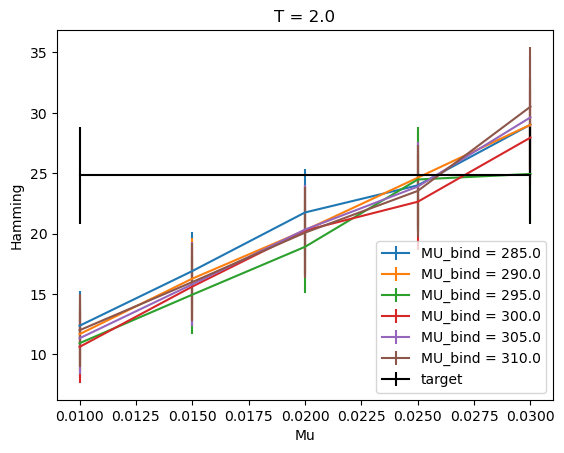

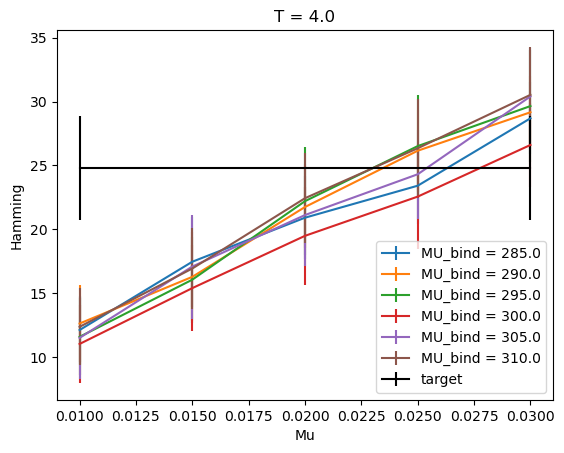

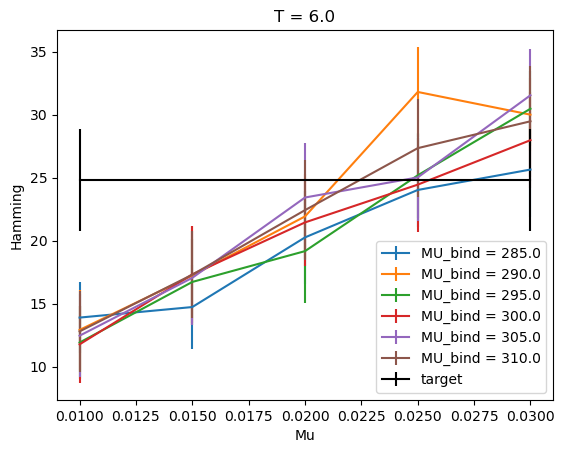

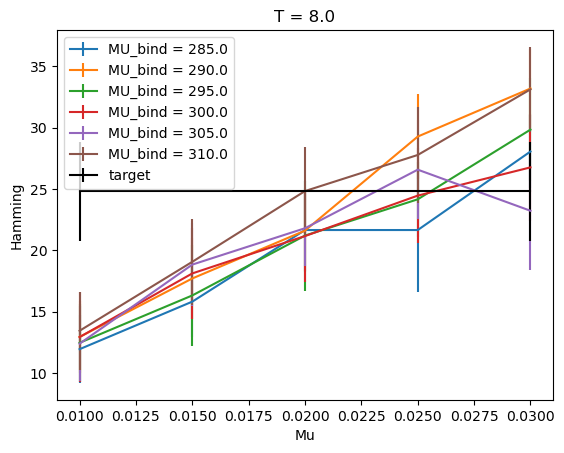

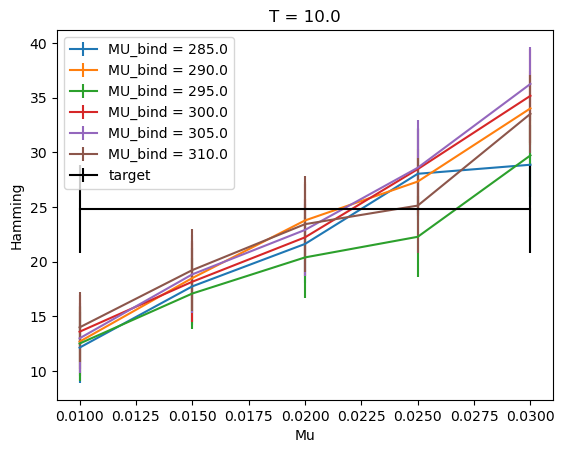

In [33]:
for t in 1:length(temps)
    plt.figure()
    for i in 1:length(mus_bind)
        plt.errorbar(mus, hams[t,:,i], yerr = hams_std[t,:,i], label = "MU_bind = $(mus_bind[i])")
    end
    plt.errorbar([0.01, 0.03], [ham_target, ham_target], 
        yerr =  [std_ham_target, std_ham_target], color = "black", label = "target")
    plt.xlabel("Mu")
    plt.ylabel("Hamming")
    plt.title("T = $(temps[t])")
    plt.legend()
    plt.show()
end


# AT ALL TEMPS MU_BIND DOESN'T CHANGE THE MEAN AND STD HAMMING 
# HAMMING INCREASES LINEARLY WITH MU



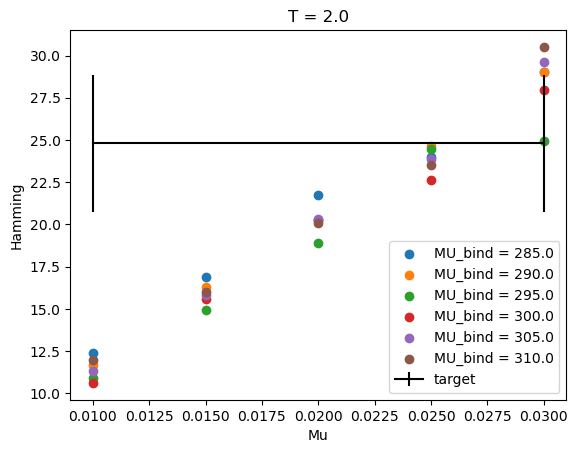

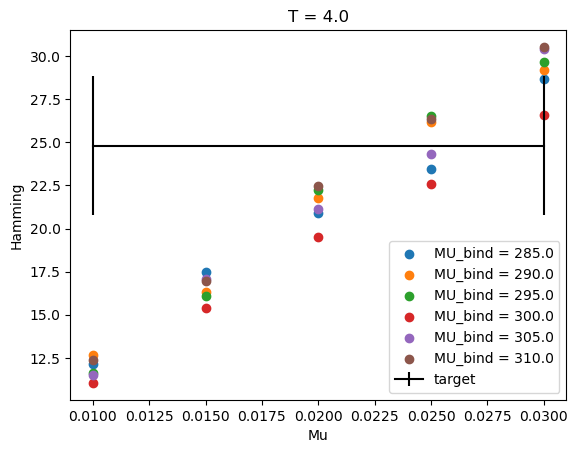

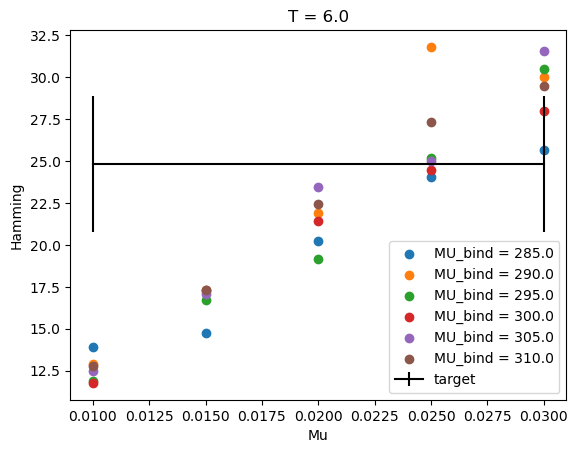

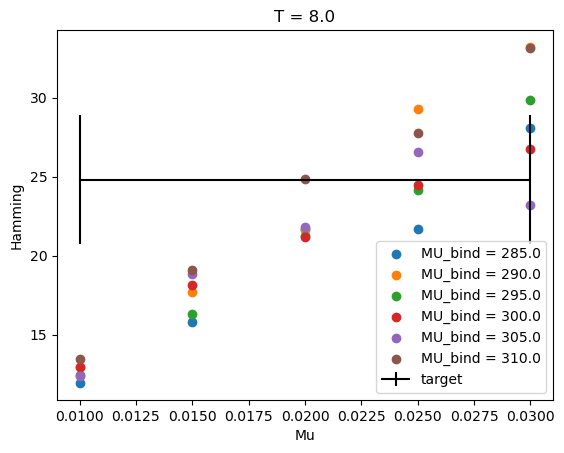

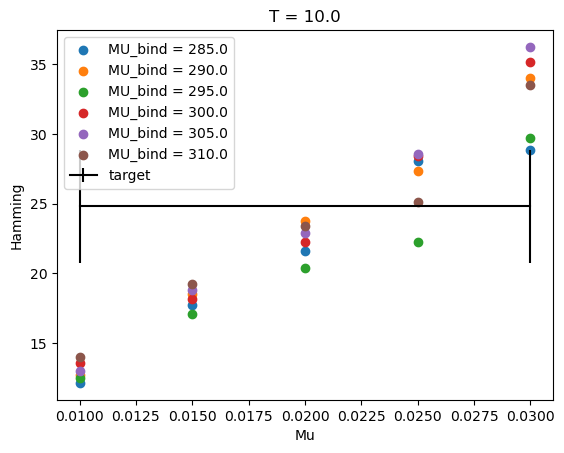

In [34]:
for t in 1:length(temps)
    plt.figure()
    for i in 1:length(mus_bind)
        plt.scatter(mus, hams[t,:,i], label = "MU_bind = $(mus_bind[i])")
    end
    plt.errorbar([0.01, 0.03], [ham_target, ham_target], 
        yerr =  [std_ham_target, std_ham_target], color = "black", label = "target")
    plt.xlabel("Mu")
    plt.ylabel("Hamming")
    plt.title("T = $(temps[t])")
    plt.legend()
    plt.show()
end


# AT ALL TEMPS MU_BIND DOESN'T CHANGE THE MEAN AND STD HAMMING 
# HAMMING INCREASES LINEARLY WITH MU

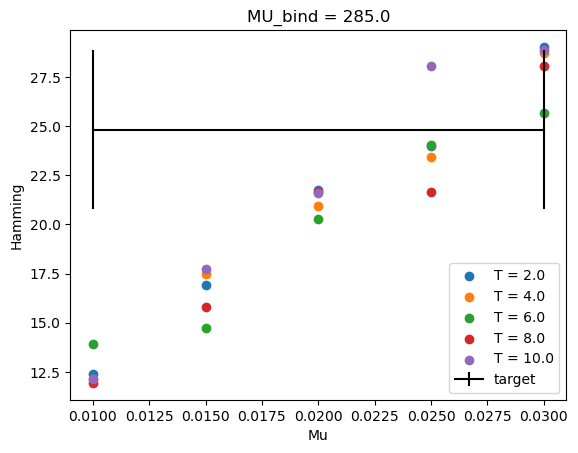

In [35]:
for t in 1:length(temps)
    plt.scatter(mus, hams[t,:,1], label = "T = $(temps[t])")
end
plt.errorbar([0.01, 0.03], [ham_target, ham_target],
    yerr =  [std_ham_target, std_ham_target], color = "black", label = "target")
plt.xlabel("Mu")
plt.ylabel("Hamming")
plt.title("MU_bind = $(mus_bind[1])")
plt.legend()
plt.show()



### Energy

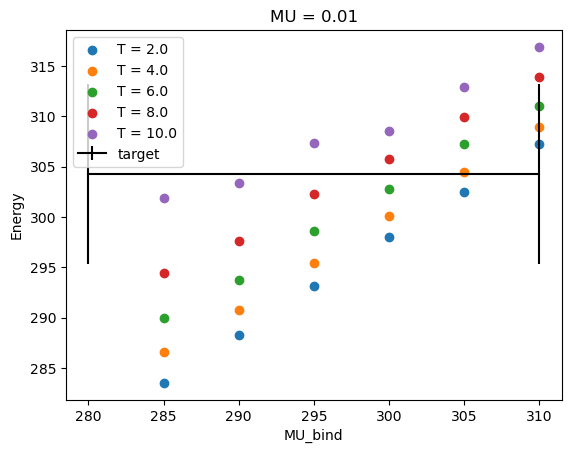

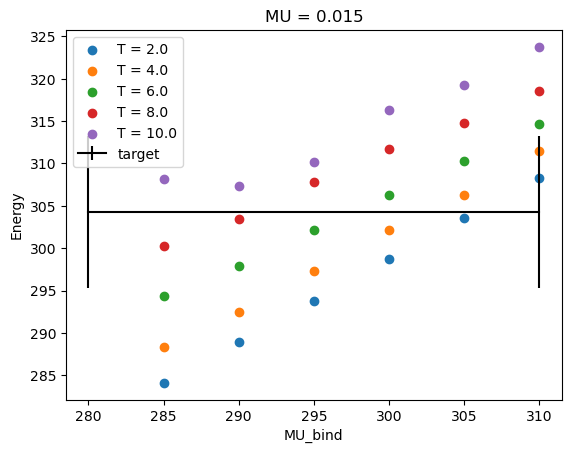

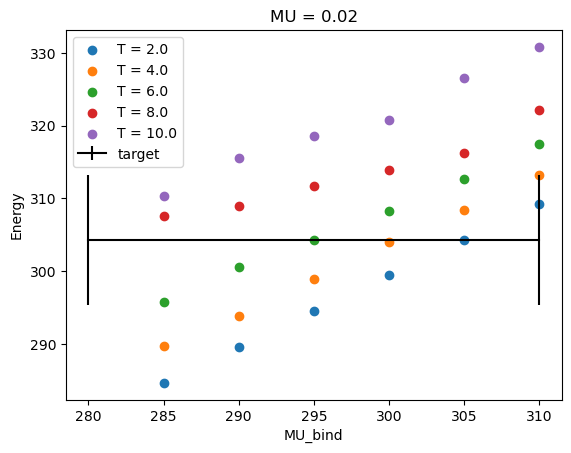

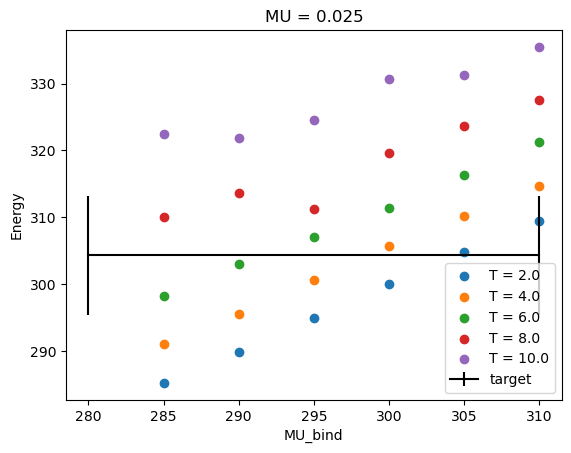

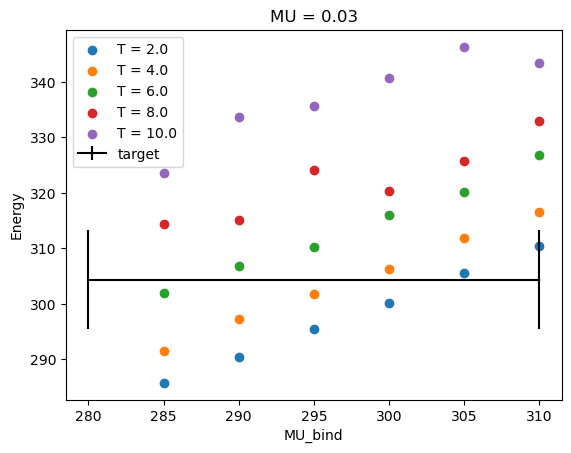

In [36]:
for i in 1:length(mus)
    plt.figure()
    for t in 1:length(temps)
        plt.scatter(mus_bind, ens[t,i,:]#, yerr = ens_std[t,i,:]
            , label = "T = $(temps[t])")
    end
    plt.errorbar([280, 310], [en_target, en_target], 
        yerr =  [std_en_target, std_en_target], color = "black", label = "target")
    plt.xlabel("MU_bind")
    plt.ylabel("Energy")
    plt.title("MU = $(mus[i])")
    plt.legend()
    plt.show()
end


# AT ALL TEMPS MU_BIND DOESN'T CHANGE THE MEAN AND STD HAMMING 
# HAMMING INCREASES LINEARLY WITH MU

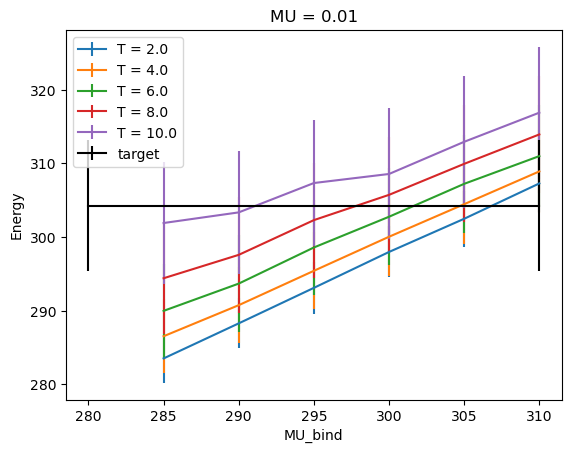

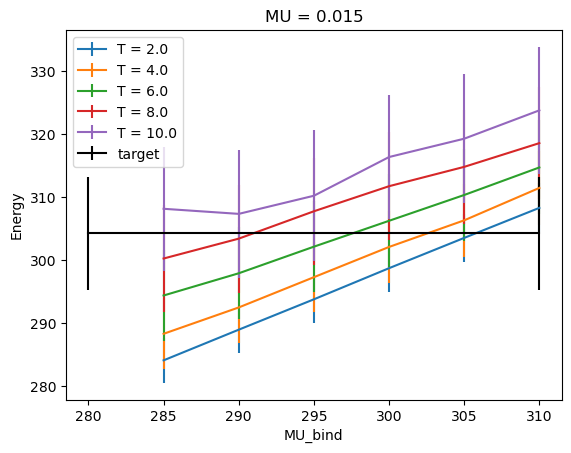

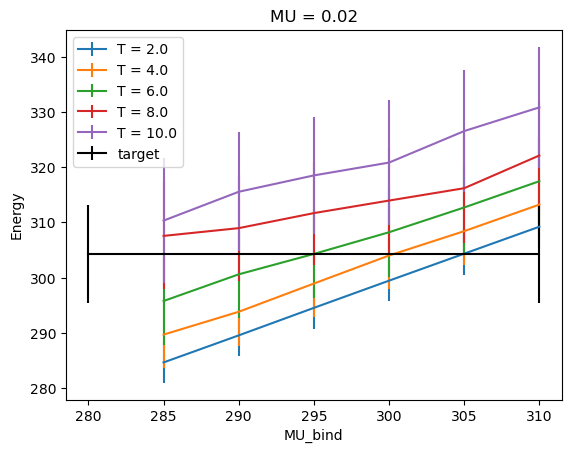

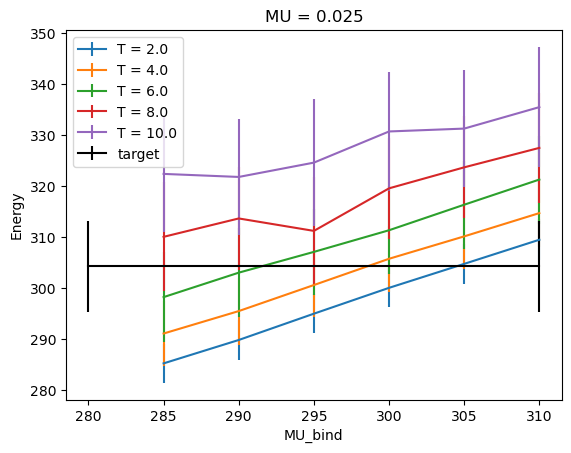

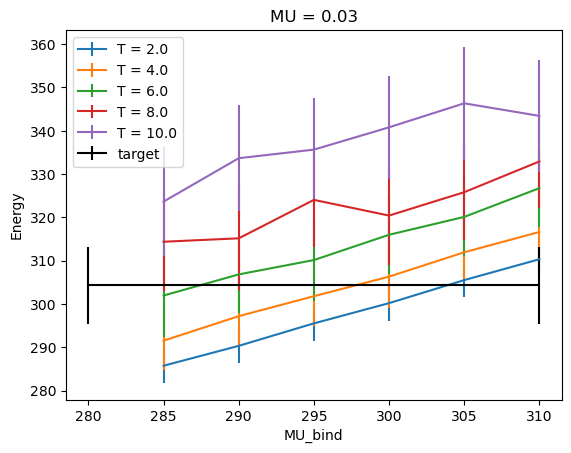

In [37]:
for i in 1:length(mus)
    plt.figure()
    for t in 1:length(temps)
        plt.errorbar(mus_bind, ens[t,i,:], yerr = ens_std[t,i,:]
            , label = "T = $(temps[t])")
    end
    plt.errorbar([280, 310], [en_target, en_target], 
        yerr =  [std_en_target, std_en_target], color = "black", label = "target")
    plt.xlabel("MU_bind")
    plt.ylabel("Energy")
    plt.title("MU = $(mus[i])")
    plt.legend()
    plt.show()
end


# AT ALL TEMPS MU_BIND DOESN'T CHANGE THE MEAN AND STD HAMMING 
# HAMMING INCREASES LINEARLY WITH MU

### Dkl

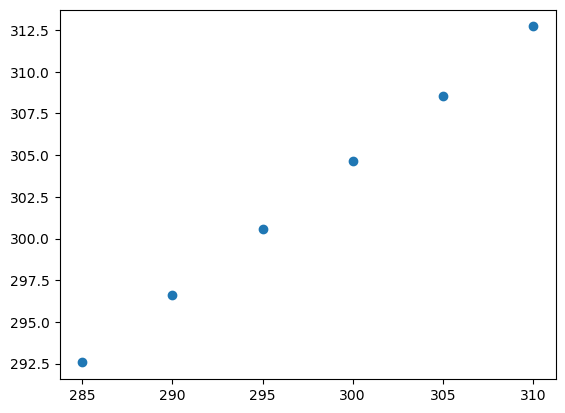

PyObject <matplotlib.collections.PathCollection object at 0x7f2df7a2b640>

In [84]:
plt.scatter(mus_bind, [mean(ens[:,:,i]) for i in 1:length(mus_bind)])

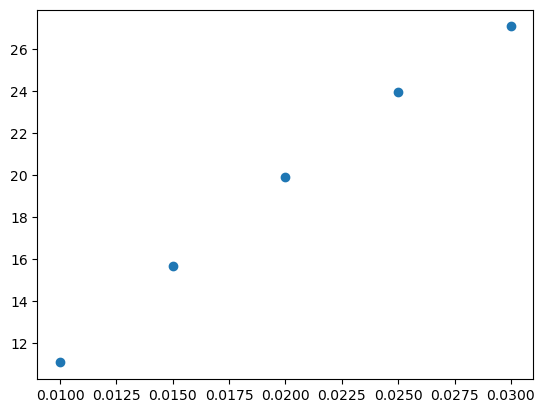

PyObject <matplotlib.collections.PathCollection object at 0x7f2df9674d00>

In [37]:
plt.scatter(mus, [mean(hams[:,i,:]) for i in 1:length(mus)])

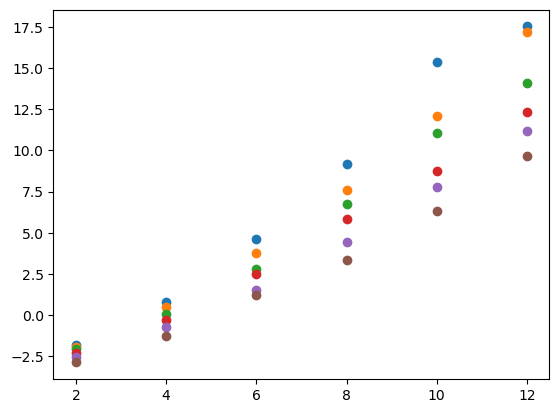

In [54]:
for m in 1:length(mus_bind)
    plt.scatter(temps, [mean(ens[i,:,m]) for i in 1:length(temps)] .- mus_bind[m])
end

## Temperatura tira su la media della energia e la std della energia

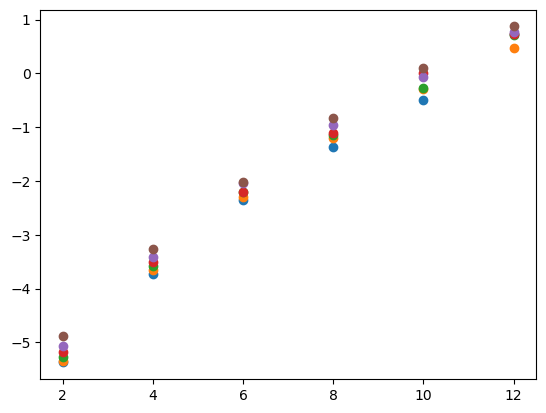

In [56]:
for m in 1:length(mus_bind)
    plt.scatter(temps, [mean(ens_std[i,:,m]) for i in 1:length(temps)] .- std_en_target)
end


### Scores

In [12]:
println(argmin(dkl_tot))
println(argmin(dkl_ens))
println(argmin(scores))
println(argmax(score_entr))

CartesianIndex(5, 4, 2)
CartesianIndex(6, 1, 4)
CartesianIndex(5, 4, 1)
CartesianIndex(1, 4, 6)


In [23]:
temps[3], mus[4], mus_bind[2]

(6.0, 0.025, 290.0)

In [25]:
score_entr[5,4,1]

0.7657072399428325

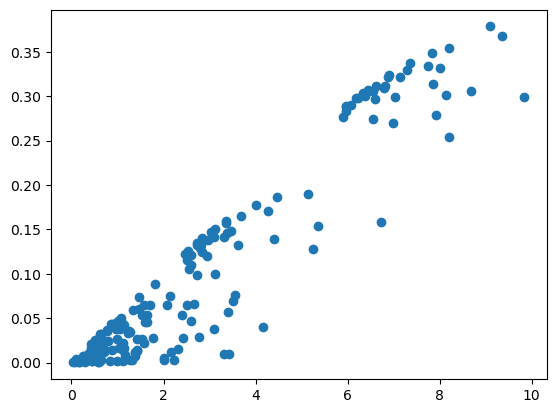

PyObject <matplotlib.collections.PathCollection object at 0x7f2df79a8c70>

In [89]:
plt.scatter(dkl_tot[:] , scores[:])

In [90]:
extrema(score_entr)

(0.6167204018471955, 0.7962946265872122)

In [103]:
ham_target / 199

0.12467802227101606

In [70]:
hams_std[3,5,1]

3.7890520026981402

In [71]:
std_ham_target

4.053813923317771

In [75]:
ens[4,2,2] - en_target

-0.8588593695408804

In [74]:
ens_std[,5,1] 

9.614909528141586

In [77]:
[Dkl_hams[3,5,1] Dkl_ens[3,5,1]]

1×2 Matrix{Float64}:
 0.0255654  0.0399402

In [78]:
[Dkl_hams[4,2,2] Dkl_ens[4,2,2]]

1×2 Matrix{Float64}:
 1.56839  0.00616187

In [79]:
[Dkl_hams[1,5,3] Dkl_ens[1,5,3]]

1×2 Matrix{Float64}:
 0.000674062  0.889142

In [81]:
[temps[3], mus[5], mus_bind[1]]

3-element Vector{Float64}:
   6.0
   0.03
 285.0

In [107]:
argmin(scores)

CartesianIndex(3, 4, 3)

### Visualization

In [152]:
using PyPlot

function plot_matrix(ax, A, A_tot, x_ticks, y_ticks, title_text )
    
    cax = ax.imshow(A, cmap="viridis", interpolation = "nearest", vmin=minimum(A_tot), vmax=maximum(A_tot))  # Color gradient
    ax.set_title(title_text, fontsize=12)
    
    nrows, ncols = size(A)
    
     # Find the maximum and minimum value positions
    max_idx = argmax(A)  # Linear index of max
    min_idx = argmin(A)  # Linear index of min
    max_i, max_j = Tuple(CartesianIndices(A)[max_idx])  # Convert to row, col
    min_i, min_j = Tuple(CartesianIndices(A)[min_idx])  # Convert to row, col

    # Mark the maximum value with a red dot
    ax.scatter(max_j-1, max_i-1, color="red", s=60, edgecolors="black", label="Max")  
    # Mark the minimum value with a blue dot
    ax.scatter(min_j-1, min_i-1, color="blue", s=60, edgecolors="black", label="Min")

    ax.set_xticks(0:(ncols-1), y_ticks, fontsize=10)
    ax.set_yticks(0:(nrows-1), x_ticks, fontsize=10)
end

plot_matrix (generic function with 3 methods)

In [160]:
using JLD2, PyPlot, Statistics
@load "../../gridsearch_popgen_nucleo.jld2"

19-element Vector{Symbol}:
 :scores
 :score_en
 :score_ham
 :score_entr
 :hams
 :hams_std
 :ens
 :ens_std
 :temps
 :mus_bind
 :mus
 :N_start
 :ham_target
 :en_target
 :std_ham_target
 :std_en_target
 :dkl_hams
 :dkl_ens
 :dkl_tot

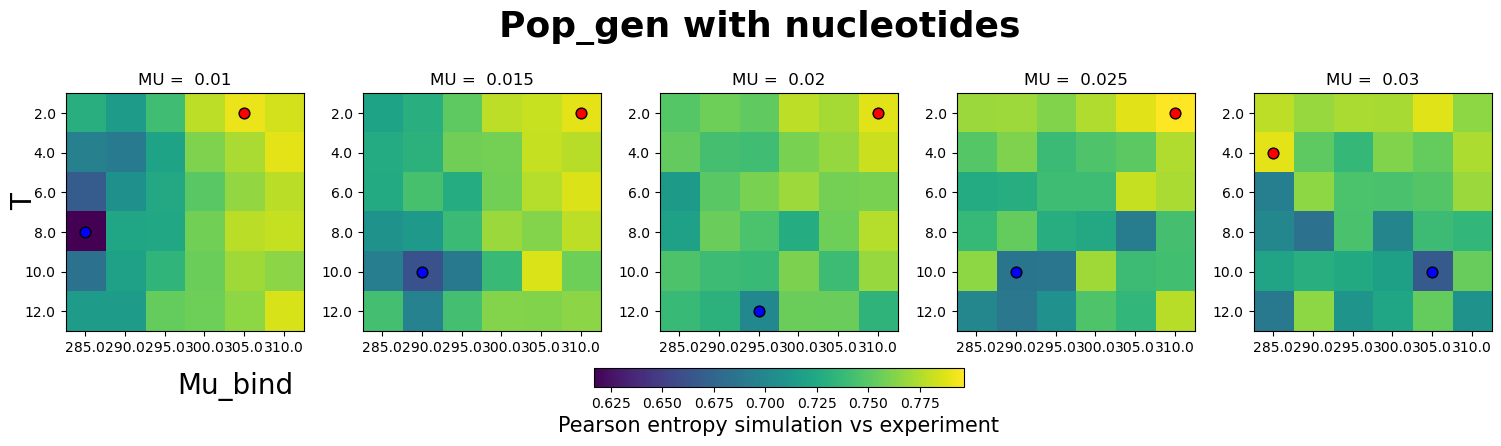

In [161]:
fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix(axes[k], score_entr[:,k,:], score_entr, temps, mus_bind, "MU =  $(mus[k])")
end
tight_layout()

fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with nucleotides", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("Pearson entropy simulation vs experiment", fontsize=15) 

savefig("../../nucleo_entropy_gridsearch.png", bbox_inches="tight")

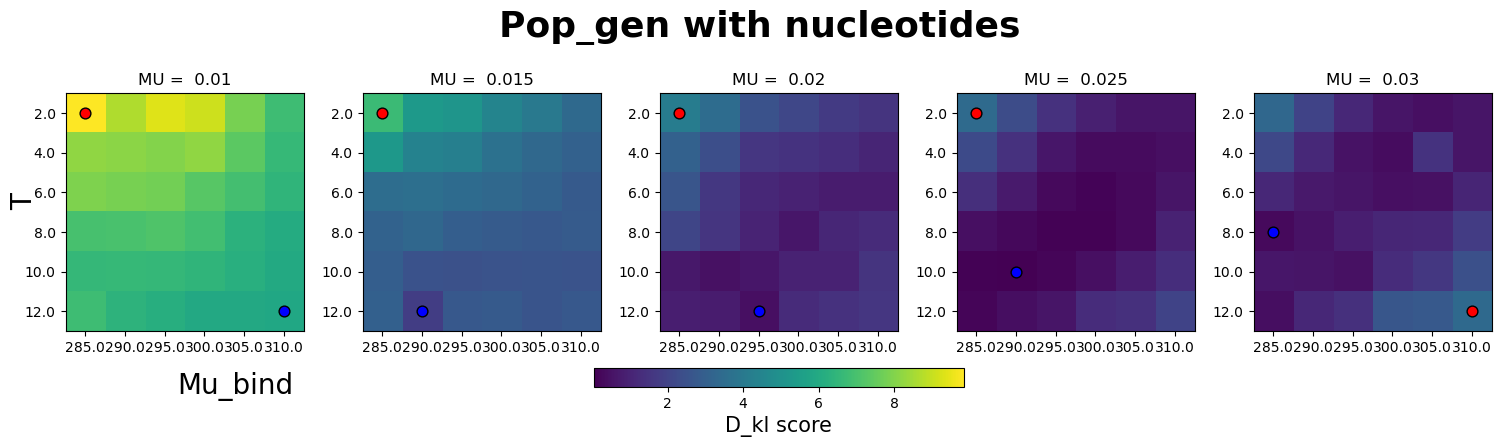

In [162]:
fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix(axes[k], dkl_tot[:,k,:], dkl_tot, temps, mus_bind, "MU =  $(mus[k])")
end

tight_layout()

fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with nucleotides", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("D_kl score", fontsize=15)  # Add legend title

savefig("../../nucleo_dkl_tot_gridsearch.png", bbox_inches="tight")


In [166]:
using JLD2, PyPlot, Statistics
@load "../../gridsearch_popgen_amino.jld2"

19-element Vector{Symbol}:
 :scores
 :score_en
 :score_ham
 :score_entr
 :hams
 :hams_std
 :ens
 :ens_std
 :temps
 :mus_bind
 :mus
 :N_start
 :ham_target
 :en_target
 :std_ham_target
 :std_en_target
 :dkl_hams
 :dkl_ens
 :dkl_tot

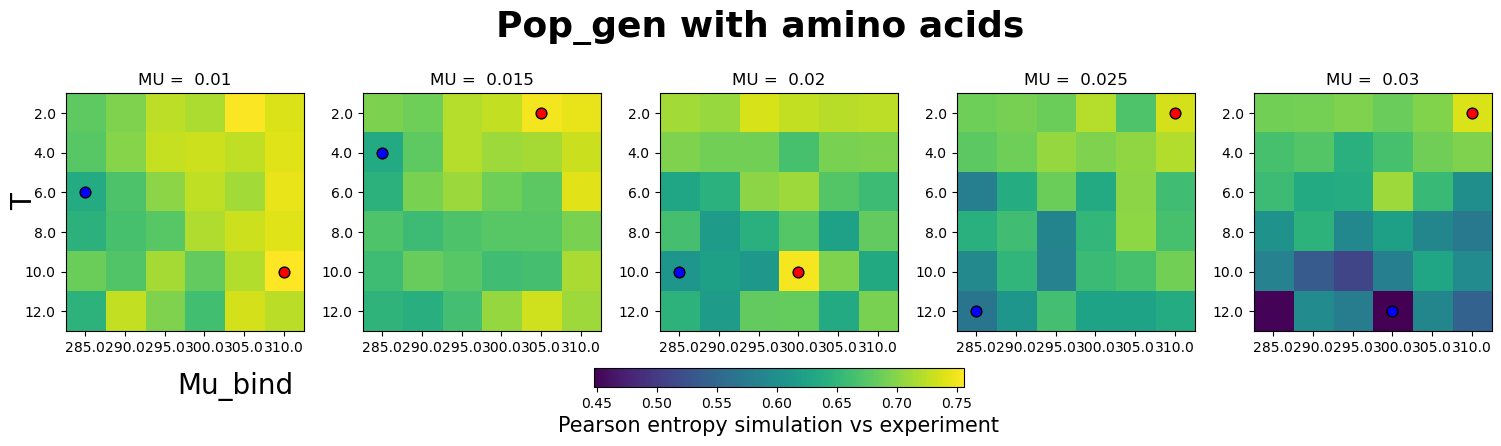

In [164]:
fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix(axes[k], score_entr[:,k,:], score_entr, temps, mus_bind, "MU =  $(mus[k])")
end
tight_layout()
fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with amino acids", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("Pearson entropy simulation vs experiment", fontsize=15) 

savefig("../../amino_entropy_gridsearch.png", bbox_inches="tight")

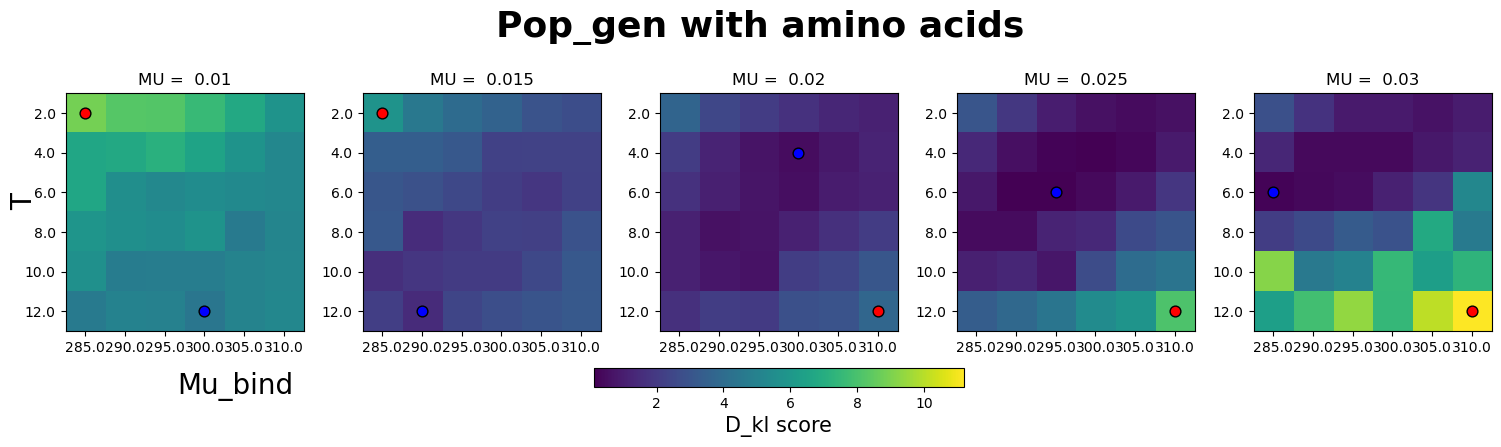

In [165]:
fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix(axes[k], dkl_tot[:,k,:], dkl_tot, temps, mus_bind, "MU =  $(mus[k])")
end

tight_layout()

fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with amino acids", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("D_kl score", fontsize=15)  # Add legend title
savefig("../../amino_dkl_tot_gridsearch.png", bbox_inches="tight")


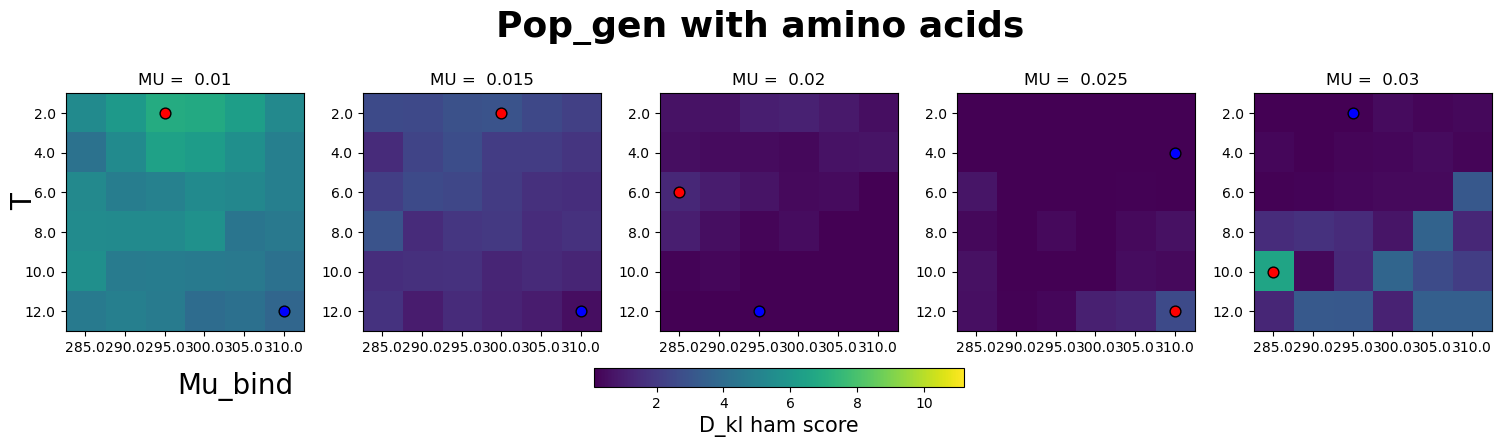

In [168]:
fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix(axes[k], dkl_hams[:,k,:], dkl_tot, temps, mus_bind, "MU =  $(mus[k])")
end

tight_layout()

fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with amino acids", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("D_kl ham score", fontsize=15)  # Add legend title
savefig("../../amino_dkl_ham_gridsearch.png", bbox_inches="tight")

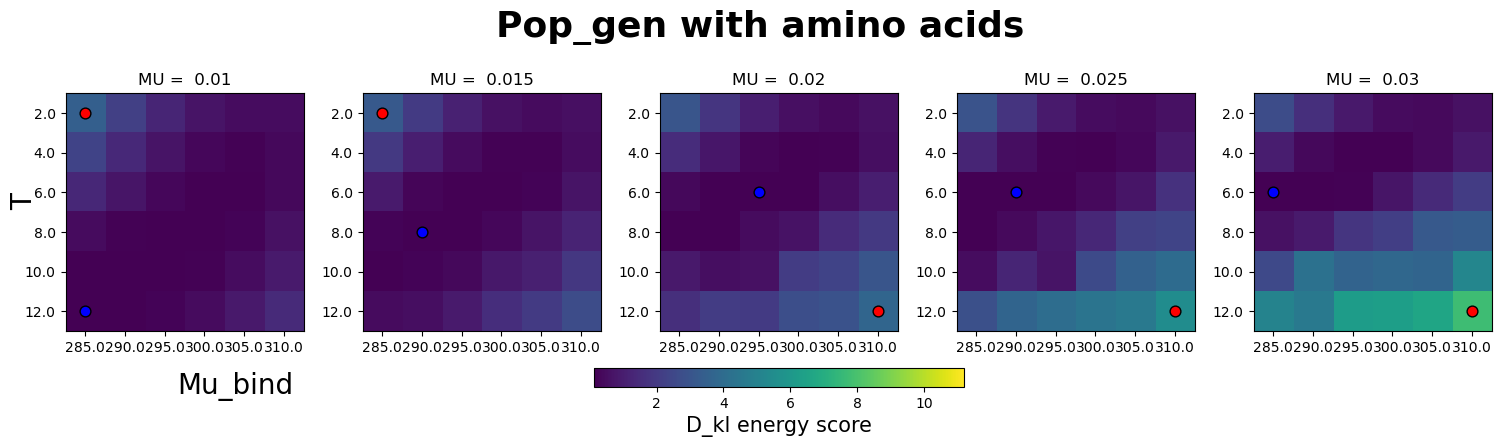

In [170]:
fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix(axes[k], dkl_ens[:,k,:], dkl_tot, temps, mus_bind, "MU =  $(mus[k])")
end

tight_layout()

fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with amino acids", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("D_kl energy score", fontsize=15)  # Add legend title
savefig("../../amino_dkl_en_gridsearch.png", bbox_inches="tight")

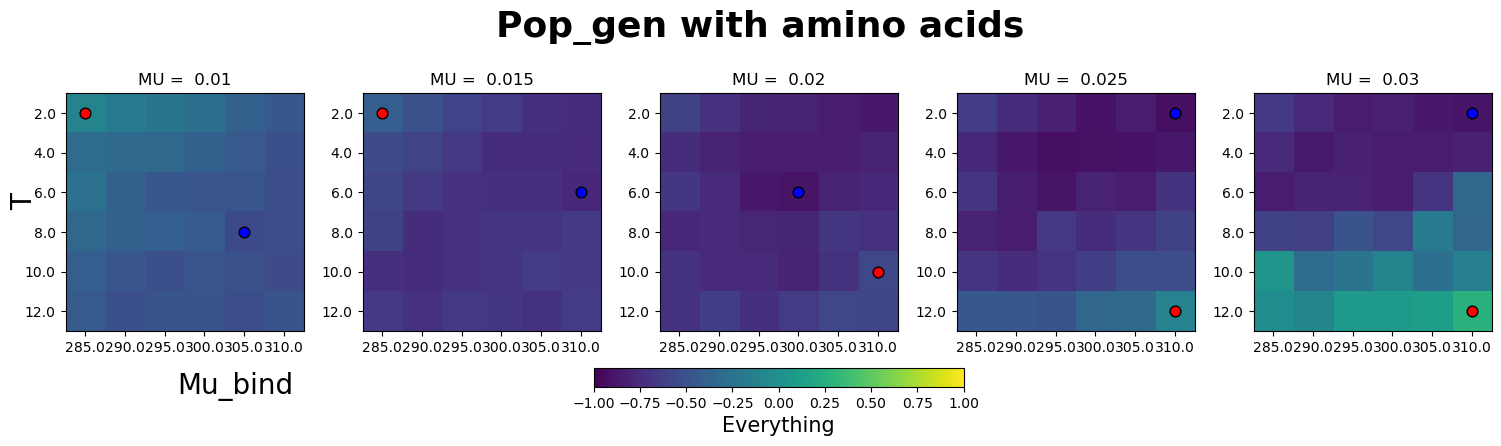

In [176]:
function plot_matrix_2(ax, A, A_tot, x_ticks, y_ticks, title_text )
    
    cax = ax.imshow(A, cmap="viridis", interpolation = "nearest", vmin=minimum(-1), vmax=maximum(1))  # Color gradient
    ax.set_title(title_text, fontsize=12)
    
    nrows, ncols = size(A)
    
     # Find the maximum and minimum value positions
    max_idx = argmax(A)  # Linear index of max
    min_idx = argmin(A)  # Linear index of min
    max_i, max_j = Tuple(CartesianIndices(A)[max_idx])  # Convert to row, col
    min_i, min_j = Tuple(CartesianIndices(A)[min_idx])  # Convert to row, col

    # Mark the maximum value with a red dot
    ax.scatter(max_j-1, max_i-1, color="red", s=60, edgecolors="black", label="Max")  
    # Mark the minimum value with a blue dot
    ax.scatter(min_j-1, min_i-1, color="blue", s=60, edgecolors="black", label="Min")

    ax.set_xticks(0:(ncols-1), y_ticks, fontsize=10)
    ax.set_yticks(0:(nrows-1), x_ticks, fontsize=10)
end


fig, axes = subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for k in 1:5
    plot_matrix_2(axes[k], (dkl_tot ./maximum(dkl_tot))[:,k,:] .- (score_entr ./maximum(score_entr))[:,k,:], dkl_tot, temps, mus_bind, "MU =  $(mus[k])")
end

tight_layout()

fig.text(0.15, 0.02, "Mu_bind", ha="center", fontsize=20)  # X label
fig.text(0.0001, 0.5, "T", va="center", rotation="vertical", fontsize=20)  # Y label

fig.suptitle("Pop_gen with amino acids", fontsize=26, fontweight="bold") 
cbar = colorbar(axes[1].images[0], ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("Everything", fontsize=15)  # Add legend title